<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preparing-Dataset" data-toc-modified-id="Preparing-Dataset-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preparing Dataset</a></span></li><li><span><a href="#Data-Annotation" data-toc-modified-id="Data-Annotation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data Annotation</a></span></li><li><span><a href="#Traning-YOLO-for-Droplet/Intruder-Detection" data-toc-modified-id="Traning-YOLO-for-Droplet/Intruder-Detection-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Traning YOLO for Droplet/Intruder Detection</a></span></li><li><span><a href="#Droplet/Intruder-Tracking" data-toc-modified-id="Droplet/Intruder-Tracking-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Droplet/Intruder Tracking</a></span></li><li><span><a href="#Inspecting-Results-and-Some-Post-Processing" data-toc-modified-id="Inspecting-Results-and-Some-Post-Processing-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Inspecting Results and Some Post-Processing</a></span></li><li><span><a href="#How-Many-Training-Images-Do-I-Need?" data-toc-modified-id="How-Many-Training-Images-Do-I-Need?-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>How Many Training Images Do I Need?</a></span></li><li><span><a href="#Tracking-with-StrongSORT" data-toc-modified-id="Tracking-with-StrongSORT-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Tracking with StrongSORT</a></span></li></ul></div>

In [1]:
import os
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
from myutils import GetVideoInfo
from myutils import CaptureFrames
from myutils import TrackDroplet
from myutils import TrainValidTestSplit
from myutils import OptimumTrainImages
from myutils import TrackMultipleExperiments
%matplotlib inline

## Preparing Dataset

- Some global variables we will keep using in this tutorial are below. We will demonstrate everything on the walking droplet experiment with 3 walkers. You should be able to train your own model by following the same steps for your own experiment


- **To create your own model using this tutorial, make sure to create your own folder instead of working on "tutorial_data" folder. Otherwise, your results will overwrite on the actual repository data**.

In [2]:
#project to be conducted
project_name = "three_droplet"

#root_dir for all tutorial data
project_dir = "tutorial_data"

#images to be used for YOLO model
raw_image_dir = "tutorial_data/raw_images/"

#image/label pairs for train/valid/test
data_dir = "tutorial_data/annotations/"

#all experiment videos are here
video_root_dir = "datasets/videos/"

#three-droplet experiment video
video_path = "datasets/videos/three_droplet.mp4"

- Assuming you have the experiment video, first step is to save some sample frames from the video source. It is always a good idea to capture only the relevant components of the experiment such as experiment corral and walkers etc. Thus you may want to crop your video before creating training data. You can use [Avidemux](https://avidemux.sourceforge.net/download.html0) which is an amazing online tool. 


- First call **"GetVideoInfo"** helper function to get an idea about the video source.

In [3]:
video_path = "datasets/videos/three_droplet.mp4"
GetVideoInfo(video_path)

frame_rate: 29
total_frames: 9034.0
length(s): 311.5
length(mins) : 5.19


- Based on the info above, decide how many frames to be captured. For example, we aim for 180 frames in total, we need to capture one frame in every (total_frames/180)/frame_rate = 1.7 second. 


- **"CaptureFrames"** function captures one frame in every *save_interval* second and save to *image_dir*.

In [4]:
CaptureFrames(video_path=video_path,image_dir = raw_image_dir,save_interval=1.7)

181 frames captured! and saved to tutorial_data/raw_images/


- We will now create a traning/validation/testing dataset from these frame. The most common ratio is 70/20/10. 


- **TrainValidTestSplit** helper function does this job. This function first creates a folder structure for train/valid/test data as 

        root_dir/X/images and root_dir/X/labels. 

- We then get images from *image_dir* and save to these folders accordingly based on the provided ratios.

In [5]:
TrainValidTestSplit(image_dir=raw_image_dir, 
                    root_dir=data_dir,train_ratio=0.7, valid_ratio=0.2, test_ratio=0.1)

127 training images copied to tutorial_data/annotations//train/images    
36 validation images copied to tutorial_data/annotations//valid/images    
18 testing images copied to tutorial_data/annotations//test/images


## Data Annotation

- Now, we are ready to annotate the all the images to create training, validation and testing data we will use for training our YOLO model. To do so we will be using free online annotation tool **LabelImg**. 


- It is super easy to use, here is a quick tutorial [here](https://www.youtube.com/watch?v=VsZvT69Ssbs). Make sure to switch YOLO format at the beginning. Annotate each images in train,valid and test images in *root_dir/X/images* folders and save them to respective *root_dir/X/labels* folder. You can simply use "droplet" as a default label name in the app.


- Just run the following cell to access its user interface. In the app, zoom-in to droplets to create high quality bounding boxes. We have already done this before. Inspect the folders inside each directory. Notice that each text file in *"labels"* folder has exactly the same name with its corresponding image file in *"images"* folder.


- If you have multiple experiments to carry out, check out Sec-6 in this notebook to get an idea about approximately how many training images you should use. You can save up quite a bit annotation time with that approach 

In [ ]:
%run -i labelImg/labelImg.py

## Traning YOLO for Droplet/Intruder Detection

- Now we are ready for model traning. First of all, find the *"tutorial_data.yml"* file in *"yolov5/custom_data"* folder and change the path variable to the directory including our train/valid/test folders. Without properly setting up this file, YOLO cannot access our data.


- Once we are done, run the following cell to train your model. It would be a better practice to run it from terminal but it does the job anyway.


- Briefly, it will train "yolov5s" architecture for 100 epochs using Adam optimizer on our data and save the results in *"project_dir/project_name"* folder. 


- By inspecting *mAP50* values, we can easily see the model is learning very quickly as values near 1 points to perfect performance. 


- **The best model will be located at *"project_dir/project_name/weights/best.pt"* . Training results can be found at *"project_dir/project_name/results.csv"***. 

In [6]:
data = "yolov5/custom_data/tutorial_data.yml"
epoch = 150
project_dir = project_dir
optimizer = "Adam"
batch_size = 32 #default YOLO
os.system(f"python  yolov5/train.py --data {data} --weights yolov5/yolov5s.pt \
          --epoch {epoch} --optimizer {optimizer} --batch-size {batch_size} \
          --project {project_dir} --name {project_name} \
          --cache --exist-ok --seed 0")

train: weights=yolov5/yolov5s.pt, cfg=, data=yolov5/custom_data/tutorial_data.yml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=150, batch_size=32, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=Adam, sync_bn=False, workers=8, project=tutorial_data, name=three_droplet, exist_ok=True, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
YOLOv5 🚀 2022-12-4 Python-3.10.8 torch-1.13.0+cu117 CUDA:0 (NVIDIA GeForce RTX 2070 Super, 7982MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, 

github: skipping check (not a git repository), for updates see https://github.com/ultralytics/yolov5


train: Scanning /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/annotations/train/labels... 127 images, 0 backgrounds, 0 corrupt: 100%|██████████| 127/127 [00:00<00:00, 14581.50it/s]
train: New cache created: /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/annotations/train/labels.cache
train: Caching images (0.1GB ram): 100%|██████████| 127/127 [00:00<00:00, 2177.59it/s]
val: Scanning /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/annotations/valid/labels... 36 images, 0 backgrounds, 0 corrupt: 100%|██████████| 36/36 [00:00<00:00, 858.35it/s]
val: New cache created: /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/annotations/valid/labels.cache
val: Caching images (0.0GB ram): 100%|██████████| 36/36 [00:00<00:00, 1090.00it/s]

AutoAnchor: 3.50 anchors/target, 1.000 Best Possible Recall (BPR). Current anchors are a good fit to dataset ✅
Plotting labels to tutorial_data/three_droplet/labe

     16/149       6.3G    0.03422   0.009073          0        113        640: 100%|██████████| 4/4 [00:01<00:00,  3.23it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s]
                   all         36        108      0.222      0.398       0.19     0.0455

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
     17/149       6.3G    0.03404   0.009248          0        144        640: 100%|██████████| 4/4 [00:01<00:00,  3.50it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 1/1 [00:00<00:00,  4.66it/s]
                   all         36        108     0.0229     0.0221    0.00457   0.000784

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
     18/149       6.3G    0.03334   0.009882          0        118        640: 100%|██████████| 4/4 [00:01<00:00,  3.57it/s]
                 

     54/149       6.3G    0.02693   0.007301          0        123        640: 100%|██████████| 4/4 [00:01<00:00,  3.47it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 1/1 [00:00<00:00,  4.35it/s]
                   all         36        108      0.643      0.963        0.8      0.316

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
     55/149       6.3G    0.02808   0.007505          0        120        640: 100%|██████████| 4/4 [00:01<00:00,  3.31it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 1/1 [00:00<00:00,  3.69it/s]
                   all         36        108      0.945      0.972      0.971       0.29

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
     56/149       6.3G    0.02847   0.007379          0        108        640: 100%|██████████| 4/4 [00:01<00:00,  3.42it/s]
                 

     92/149       6.3G    0.02554    0.00668          0        115        640: 100%|██████████| 4/4 [00:01<00:00,  3.56it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 1/1 [00:00<00:00,  4.27it/s]
                   all         36        108      0.999          1      0.995      0.461

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
     93/149       6.3G    0.02601   0.007002          0        111        640: 100%|██████████| 4/4 [00:01<00:00,  3.48it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 1/1 [00:00<00:00,  3.99it/s]
                   all         36        108      0.999          1      0.995      0.473

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
     94/149       6.3G    0.02485   0.007077          0         97        640: 100%|██████████| 4/4 [00:01<00:00,  3.46it/s]
                 

    130/149       6.3G    0.02324   0.006301          0         93        640: 100%|██████████| 4/4 [00:01<00:00,  3.48it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 1/1 [00:00<00:00,  4.24it/s]
                   all         36        108      0.999          1      0.995      0.499

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
    131/149       6.3G     0.0229   0.006534          0        120        640: 100%|██████████| 4/4 [00:01<00:00,  3.36it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 1/1 [00:00<00:00,  3.34it/s]
                   all         36        108      0.999          1      0.995      0.492

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
    132/149       6.3G    0.02365   0.006376          0        133        640: 100%|██████████| 4/4 [00:01<00:00,  3.19it/s]
                 

0

- Now let's test the best model on our test data. "mAP50" value looks pretty good. it indicates that we will most likely obtain very high detection rate when we process the actual experiment video. This comes in the next section. 

- **If *mAP50* value on testing data is way below 0.90, that means the model is did not learn enough thus fails to generalize to unseen data. Based on our experience, first start by increasing the the number of epochs to a high number say 400. If the behaviour is the same, increasing the number of training images may help. Add 20-30 images/labels to the training data. You can also increase the batch_size**. 

In [7]:
model_path = f"{project_dir}/{project_name}/weights/best.pt"
os.system(f"python yolov5/val.py --data {data}  --weights {model_path} --task test")

val: data=yolov5/custom_data/tutorial_data.yml, weights=['tutorial_data/three_droplet/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=yolov5/runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 2022-12-4 Python-3.10.8 torch-1.13.0+cu117 CUDA:0 (NVIDIA GeForce RTX 2070 Super, 7982MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
test: Scanning /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/annotations/test/labels... 18 images, 0 backgrounds, 0 corrupt: 100%|██████████| 18/18 [00:00<00:00, 2415.76it/s]
test: New cache created: /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/annotations/test/labels.cache
                 Class     Images  Instances          P          R      mAP50   m

0

## Droplet/Intruder Tracking

- Once the model is trained, you will find the best model at *"tutorial_data/myproject/weights/best.pt"* as noted above.


- To visualize and save the tracking results, simply modify the following cell. **TrackDroplet** returns number of detected frames, total frames and a dataframe including positions, velocity, confidence scores for each individual droplet/intruder in the video source. This dataframe is saved to *"save_dir"* as a *"save_name.csv"* in **real time**. Ignore if you get "QObject::moveToThread" error. It also saves the tracking video in the same directory.


- Make sure to properly enter "number of objects(droplets/intruders) and video_path, model_path etc. If you spot any false positives, try increasing the threshold slightly. You can always interrupt the simulation by pressing "q" on your keyboard. All information is saved in real-time.

In [8]:
#number of droplet(s)/intruder(s)
nd = 3

#best YOLO Pytorch model path
model_path = f"{project_dir}/{project_name}/weights/best.pt"
model = torch.hub.load('ultralytics/yolov5', 'custom', path=model_path)

#accept if only all detections are above this thresold
conf_thresold = 0.45


#False: show only bounding box, True: show trajectory
show_trace = True

detected,total_frame,df = TrackDroplet(model= model,conf_thresold=conf_thresold,nd=nd,
                                    video_path=video_path, save_dir=project_dir,
                                    save_name=project_name, show_trace=show_trace)

Using cache found in /home/erkara/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-12-7 Python-3.10.8 torch-1.13.0+cu117 CUDA:0 (NVIDIA GeForce RTX 2070 Super, 7982MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 
QObject::moveToThread: Current thread (0x55dd11d16d00) is not the object's thread (0x55dd11beace0).
Cannot move to target thread (0x55dd11d16d00)

QObject::moveToThread: Current thread (0x55dd11d16d00) is not the object's thread (0x55dd11beace0).
Cannot move to target thread (0x55dd11d16d00)

QObject::moveToThread: Current thread (0x55dd11d16d00) is not the object's thread (0x55dd11beace0).
Cannot move to target thread (0x55dd11d16d00)

QObject::moveToThread: Current thread (0x55dd11d16d00) is not the object's thread (0x55dd11beace0).
Cannot move to target thread (0x55dd11d16d00)

QObject::moveToThread: Current thread (0x55dd11d16d00) is not the object's thread (0x55dd11beace0).
Cannot move to target t

8430/9033=93.32% detected! in         three_droplet experiment

results are saved to tutorial_data...


- If you have a model trained for multiple experiments, you can also those experiments all at once using **"TrackMultipleExperiments"** functions. As outlined in the paper **"best_droplet.pt"** is the model we trained for all droplet experiments. The code below shows how to use it to track multiple experiments. At the end, we save frame detection rates for each experiment to save_dir/name.csv. You can always interrupt the simulation by pressing "q" on your keyboard.



- Make sure the keys in exp_dict is exactly the same with the video names in *video_root_dir* and provide the number of droplet/intruder associated with the corresponding video source.

In [9]:
#experiment names and object number(s)
exp_dict = {'control':1, 'lights_off':1}

#root directory having all the videos
video_root_dir = video_root_dir

#best YOLO Pytorch model path
model = torch.hub.load('ultralytics/yolov5', 'custom', path="best_droplet.pt")


#detect above this value
conf_thresold = 0.45

#save dir
save_dir = project_dir


#save name for dataframe
name = "frame_detection_rates"

#True shows the trajectory
show_trace = False

#track exps in exp_dict
TrackMultipleExperiments(exp_dict=exp_dict,video_root_dir=video_root_dir,model=model,
                         conf_thresold=conf_thresold,
                         save_dir=save_dir, name=name, show_trace=False
                         )

Using cache found in /home/erkara/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-12-7 Python-3.10.8 torch-1.13.0+cu117 CUDA:0 (NVIDIA GeForce RTX 2070 Super, 7982MiB)

Fusing layers... 
Model summary: 213 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 
QObject::moveToThread: Current thread (0x55dd11d16d00) is not the object's thread (0x55dd11beace0).
Cannot move to target thread (0x55dd11d16d00)

QObject::moveToThread: Current thread (0x55dd11d16d00) is not the object's thread (0x55dd11beace0).
Cannot move to target thread (0x55dd11d16d00)

QObject::moveToThread: Current thread (0x55dd11d16d00) is not the object's thread (0x55dd11beace0).
Cannot move to target thread (0x55dd11d16d00)

QObject::moveToThread: Current thread (0x55dd11d16d00) is not the object's thread (0x55dd11beace0).
Cannot move to target thread (0x55dd11d16d00)

QObject::moveToThread: Current thread (0x55dd11d16d00) is not the object's thread (0x55dd11beace0).
Cannot move to target t

['control', 1]
7491/7494=99.96% detected! in         control experiment

results are saved to tutorial_data...
['lights_off', 1]


QObject::moveToThread: Current thread (0x55dd11d16d00) is not the object's thread (0x55dd11beace0).
Cannot move to target thread (0x55dd11d16d00)

QObject::moveToThread: Current thread (0x55dd11d16d00) is not the object's thread (0x55dd11beace0).
Cannot move to target thread (0x55dd11d16d00)

QObject::moveToThread: Current thread (0x55dd11d16d00) is not the object's thread (0x55dd11beace0).
Cannot move to target thread (0x55dd11d16d00)

QObject::moveToThread: Current thread (0x55dd11d16d00) is not the object's thread (0x55dd11beace0).
Cannot move to target thread (0x55dd11d16d00)

QObject::moveToThread: Current thread (0x55dd11d16d00) is not the object's thread (0x55dd11beace0).
Cannot move to target thread (0x55dd11d16d00)

QObject::moveToThread: Current thread (0x55dd11d16d00) is not the object's thread (0x55dd11beace0).
Cannot move to target thread (0x55dd11d16d00)

QObject::moveToThread: Current thread (0x55dd11d16d00) is not the object's thread (0x55dd11beace0).
Cannot move to tar

7859/7884=99.68% detected! in         lights_off experiment

results are saved to tutorial_data...


## Inspecting Results and Some Post-Processing

- Let's inspect the results regarding our original experiment.We will start by loading the dataframe we saved. Or you can directly use it as it is return by  **TrackDroplet** function. This was the major goal of this tutorial. You can analyze this data in a way you wish. 


- **frame_id, time, x, y, c, dx,dy speed** columns refers to the frame number, time stamp(sec), x-position,y-position,x-velocity,y-velocity and speed of each individual droplet/intruder tracked. 



- For example, using the plot function below, we can overlay the position and the flow of the object.

In [10]:
df = pd.read_csv(f"{project_dir}/{project_name}.csv")
df.head()

,frame_id,time,x1,y1,x2,...,dy2,speed2,dx3,dy3,speed3
0,1.0,0.000000,268.051239,111.549988,166.191910,...,0.000000,0.000000,0.000000,0.000000,0.000000
1,2.0,0.033333,269.345032,111.981018,165.370789,...,-16.895599,29.871011,-47.333679,-14.861526,49.611915
2,3.0,0.066667,270.889954,112.496429,164.428009,...,-13.333969,31.268909,-51.446686,-10.479355,52.503127
3,4.0,0.100000,272.493256,112.932266,163.546219,...,-13.557587,29.725522,-43.648224,-15.727158,46.395161
4,5.0,0.133333,273.872009,113.363586,162.708496,...,-16.198654,29.899798,-22.621765,-15.417252,27.375827


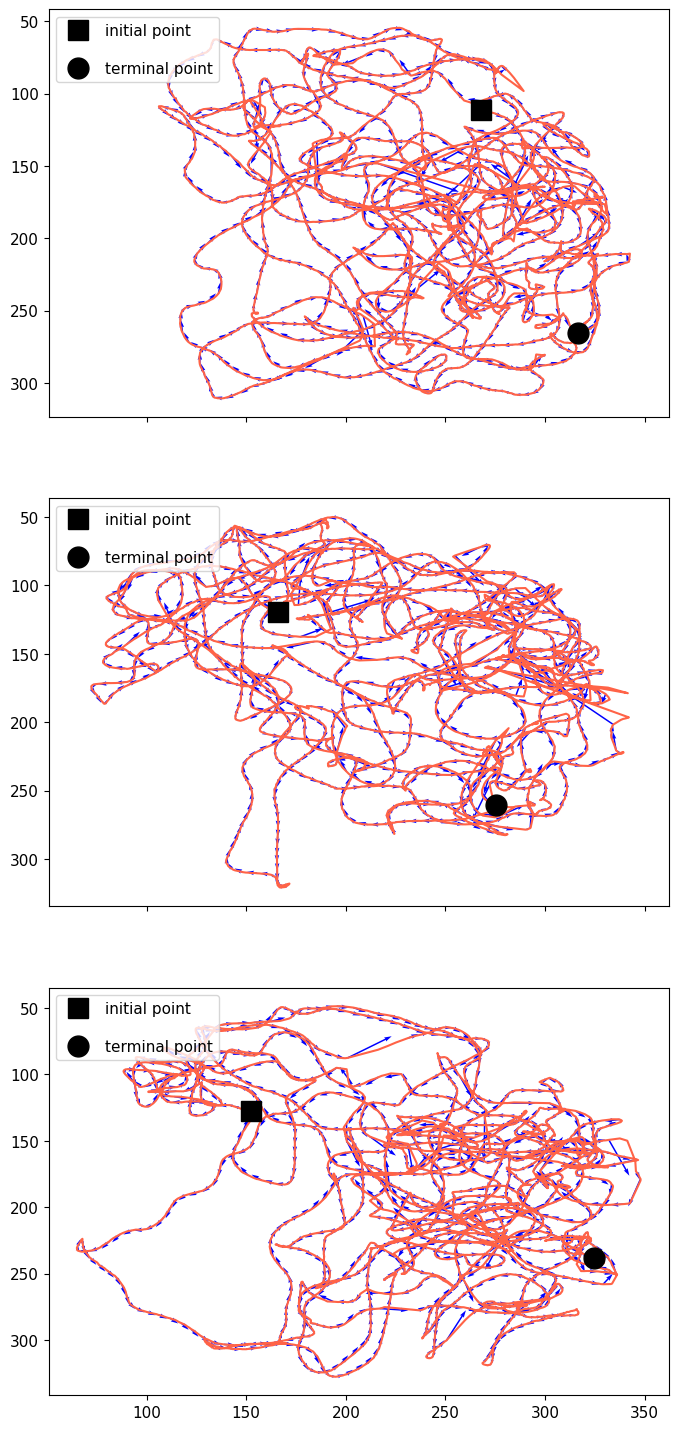

In [11]:
def GetDynamics(df,nd):    
    xlist = [f"x{i}" for i in range(1,nd+1)]
    dxlist = [f"dx{i}" for i in range(1,nd+1)]

    ylist = [f"y{i}" for i in range(1,nd+1)]
    dylist = [f"dy{i}" for i in range(1,nd+1)]

    slist = [f"speed{i}" for i in range(1,nd+1)]

    #get stuff column-wise
    t = df["time"].to_numpy()
    xc = df[xlist].to_numpy()
    dx = df[dxlist].to_numpy()

    yc = df[ylist].to_numpy()
    dy = df[dylist].to_numpy()

    speed = df[slist].to_numpy()
    
    return t, xc, yc, dx, dy, speed

def PlotFlow(nd,df,sample_interval=5):
    _, xc, yc, _, _, _ = GetDynamics(df,nd)
    fig,ax = plt.subplots(3,1,figsize=(8,18),sharex=True)
    for i in range(nd):
        X = xc[:,i]
        Y = yc[:,i]
        x = X[0:-1:sample_interval]
        y = Y[0:-1:sample_interval]
        dx = np.diff(x)
        dy = np.diff(y)
        dx1 = np.append(dx, 0)
        dy1 = -np.append(dy, 0)
        ax[i].plot(X, Y, linestyle='-', color='tomato')
        ax[i].quiver(x, y, dx1, dy1, color='blue', units='width')
        ax[i].plot(x[0], y[0], 'ks', label='initial point', markersize=15)
        ax[i].plot(x[-1], y[-1], 'ko', label='terminal point', markersize=15)
        ax[i].invert_yaxis()
        ax[i].legend(loc='upper left',labelspacing = 1.5)
    plt.show()
    
#restart and run again if you dont see images. YOLO has a tiny conflict with  plt.show()
%matplotlib inline
PlotFlow(nd=3,df=df)

## How Many Training Images Do I Need?

- We cannot give a definitive answer this question but we can make a quick experiment. 


- We have a folder "data_dir = tutorial_data/annotations", including all of our training data. We are uncertain as to whether the amount of training images is adequate to create an effective model, or if it is excessive. The later item is important if we are to repeat similar experiments multiple times. So the idea is the following;


- Train the model with increasing number of training images by keeping 70%/20% train/valid ratio but keep the same number of testing images. Then monitor mAP scores vs number of training images. Let's say we have 70/20/10 train/valid/test images in our original dataset. We can train the model with 20/6/10, 40/12/10, 60/18/10 partitions and check how mAPs are changing for each case.


- We are looking for some sort of asymptotic behaviour of  mAP0.5. We can then pick the number of images slightly after asymptotic behaviour started. This should give us a good estimate on the optimal number of images for our dataset so that we do not need to spend huge amount of time to annotate lots of images.  


- To  much talking, **OptimumTrainImages** should do the job. Pick *max_image_number* images as an upper bound. This should not exceed the number of training images you initially prepared. We will test each case between *start_image_num* and final_imag_num with *num_interval* intervals. Pick a reasonable *epoch* number for each cycle. Recall that this is not the actual training, we would like to get a quick estimate. Thus 50 should do the job.. Outcome is  a dataframe in the *"project_dir"* with columns *num_train_image,mAP@[0.5],mAP@[0.5..0.95]*. The function will give you a plot anyway but you can use that file as well. This simulation should take around 25 minutes.


- The final plot indicates that we should get pretty much the same performance just by using slightly more than 60 images.

we will train model with [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120] training images
updated tutorial_data/temp/train/images folder with 5 new images/labels out of 127 from tutorial_data/annotations//train
updated tutorial_data/temp/valid/images folder with 2 new images/labels out of 36 from tutorial_data/annotations//valid
beginning traning with 5 images


train: weights=yolov5/yolov5s.pt, cfg=, data=yolov5/custom_data/temp.yml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=True, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=Adam, sync_bn=False, workers=8, project=tutorial_data, name=temp_results, exist_ok=True, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
YOLOv5 🚀 2022-12-4 Python-3.10.8 torch-1.13.0+cu117 CUDA:0 (NVIDIA GeForce RTX 2070 Super, 7982MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, degrees=0.0,

github: skipping check (not a git repository), for updates see https://github.com/ultralytics/yolov5


train: Scanning /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/temp/train/labels... 5 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5/5 [00:00<00:00, 2388.01it/s]
train: New cache created: /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/temp/train/labels.cache
train: Caching images (0.0GB ram): 100%|██████████| 5/5 [00:00<00:00, 1094.83it/s]
val: Scanning /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/temp/valid/labels... 2 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2/2 [00:00<00:00, 782.37it/s]
val: New cache created: /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/temp/valid/labels.cache

AutoAnchor: 3.73 anchors/target, 1.000 Best Possible Recall (BPR). Current anchors are a good fit to dataset ✅
Plotting labels to tutorial_data/temp_results/labels.jpg... 
Image sizes 640 train, 640 val
Using 5 dataloader workers
Logging results to tutorial_data/temp_results
Starting tr


      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
      35/49      1.22G    0.04974    0.01359          0          6        640: 100%|██████████| 1/1 [00:00<00:00, 17.74it/s]

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
      36/49      1.22G    0.05116    0.02163          0         10        640: 100%|██████████| 1/1 [00:00<00:00, 11.42it/s]

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
      37/49      1.22G    0.07146    0.01986          0         19        640: 100%|██████████| 1/1 [00:00<00:00, 14.83it/s]

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
      38/49      1.22G    0.06063    0.01364          0         10        640: 100%|██████████| 1/1 [00:00<00:00, 11.84it/s]

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
      39/49      1.22G     0.0553    0.01979          0         14        640: 100%|██████████| 1/1 [00:0

testing the best model trained with 5 images


val_erdi: data=yolov5/custom_data/temp.yml, weights=['tutorial_data/temp_results/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=yolov5/runs/val, name=exp, exist_ok=False, half=False, dnn=False, num_train=5, mysave_dir=tutorial_data, mycsv_name=test_scores
YOLOv5 🚀 2022-12-4 Python-3.10.8 torch-1.13.0+cu117 CUDA:0 (NVIDIA GeForce RTX 2070 Super, 7982MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
test: Scanning /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/temp/test/labels... 18 images, 0 backgrounds, 0 corrupt: 100%|██████████| 18/18 [00:00<00:00, 2321.28it/s]
test: New cache created: /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/temp/test/labels.cache
                 Class     Images  In

saving csv results to tutorial_data
updated tutorial_data/temp/train/images folder with 10 new images/labels out of 127 from tutorial_data/annotations//train
updated tutorial_data/temp/valid/images folder with 3 new images/labels out of 36 from tutorial_data/annotations//valid
beginning traning with 10 images


train: weights=yolov5/yolov5s.pt, cfg=, data=yolov5/custom_data/temp.yml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=True, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=Adam, sync_bn=False, workers=8, project=tutorial_data, name=temp_results, exist_ok=True, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
YOLOv5 🚀 2022-12-4 Python-3.10.8 torch-1.13.0+cu117 CUDA:0 (NVIDIA GeForce RTX 2070 Super, 7982MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, degrees=0.0,

github: skipping check (not a git repository), for updates see https://github.com/ultralytics/yolov5


train: Scanning /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/temp/train/labels... 10 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<00:00, 5450.69it/s]
train: New cache created: /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/temp/train/labels.cache
train: Caching images (0.0GB ram): 100%|██████████| 10/10 [00:00<00:00, 1653.64it/s]
val: Scanning /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/temp/valid/labels... 3 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3/3 [00:00<00:00, 1021.75it/s]
val: New cache created: /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/temp/valid/labels.cache

AutoAnchor: 3.63 anchors/target, 1.000 Best Possible Recall (BPR). Current anchors are a good fit to dataset ✅
Plotting labels to tutorial_data/temp_results/labels.jpg... 
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to tutorial_data/temp_results
Start


      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
      35/49      2.29G     0.0441    0.03102          0         41        640: 100%|██████████| 1/1 [00:00<00:00, 10.32it/s]

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
      36/49      2.29G     0.0454    0.02973          0         44        640: 100%|██████████| 1/1 [00:00<00:00,  8.19it/s]

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
      37/49      2.29G    0.04475    0.03173          0         63        640: 100%|██████████| 1/1 [00:00<00:00, 10.70it/s]

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
      38/49      2.29G    0.04388    0.03192          0         46        640: 100%|██████████| 1/1 [00:00<00:00,  8.39it/s]

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
      39/49      2.29G    0.04397    0.02995          0         41        640: 100%|██████████| 1/1 [00:0

testing the best model trained with 10 images


val_erdi: data=yolov5/custom_data/temp.yml, weights=['tutorial_data/temp_results/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=yolov5/runs/val, name=exp, exist_ok=False, half=False, dnn=False, num_train=10, mysave_dir=tutorial_data, mycsv_name=test_scores
YOLOv5 🚀 2022-12-4 Python-3.10.8 torch-1.13.0+cu117 CUDA:0 (NVIDIA GeForce RTX 2070 Super, 7982MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
test: Scanning /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/temp/test/labels.cache... 18 images, 0 backgrounds, 0 corrupt: 100%|██████████| 18/18 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s]
                   all   

saving csv results to tutorial_data
updated tutorial_data/temp/train/images folder with 15 new images/labels out of 127 from tutorial_data/annotations//train
updated tutorial_data/temp/valid/images folder with 5 new images/labels out of 36 from tutorial_data/annotations//valid
beginning traning with 15 images


train: weights=yolov5/yolov5s.pt, cfg=, data=yolov5/custom_data/temp.yml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=True, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=Adam, sync_bn=False, workers=8, project=tutorial_data, name=temp_results, exist_ok=True, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
YOLOv5 🚀 2022-12-4 Python-3.10.8 torch-1.13.0+cu117 CUDA:0 (NVIDIA GeForce RTX 2070 Super, 7982MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, degrees=0.0,

github: skipping check (not a git repository), for updates see https://github.com/ultralytics/yolov5


train: Scanning /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/temp/train/labels... 15 images, 0 backgrounds, 0 corrupt: 100%|██████████| 15/15 [00:00<00:00, 6524.38it/s]
train: New cache created: /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/temp/train/labels.cache
train: Caching images (0.0GB ram): 100%|██████████| 15/15 [00:00<00:00, 1743.75it/s]
val: Scanning /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/temp/valid/labels... 5 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5/5 [00:00<00:00, 1510.15it/s]
val: New cache created: /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/temp/valid/labels.cache

AutoAnchor: 3.44 anchors/target, 1.000 Best Possible Recall (BPR). Current anchors are a good fit to dataset ✅
Plotting labels to tutorial_data/temp_results/labels.jpg... 
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to tutorial_data/temp_results
Start


      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
      35/49      3.14G    0.04193    0.02343          0         65        640: 100%|██████████| 1/1 [00:00<00:00,  7.75it/s]

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
      36/49      3.14G    0.03943    0.01936          0         43        640: 100%|██████████| 1/1 [00:00<00:00,  6.35it/s]

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
      37/49      3.14G    0.04459     0.0207          0         70        640: 100%|██████████| 1/1 [00:00<00:00,  7.54it/s]

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
      38/49      3.14G     0.0448    0.02067          0         67        640: 100%|██████████| 1/1 [00:00<00:00,  6.25it/s]

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
      39/49      3.14G    0.04485    0.01778          0         68        640: 100%|██████████| 1/1 [00:0

testing the best model trained with 15 images


val_erdi: data=yolov5/custom_data/temp.yml, weights=['tutorial_data/temp_results/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=yolov5/runs/val, name=exp, exist_ok=False, half=False, dnn=False, num_train=15, mysave_dir=tutorial_data, mycsv_name=test_scores
YOLOv5 🚀 2022-12-4 Python-3.10.8 torch-1.13.0+cu117 CUDA:0 (NVIDIA GeForce RTX 2070 Super, 7982MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
test: Scanning /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/temp/test/labels.cache... 18 images, 0 backgrounds, 0 corrupt: 100%|██████████| 18/18 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s]
                   all   

saving csv results to tutorial_data
updated tutorial_data/temp/train/images folder with 20 new images/labels out of 127 from tutorial_data/annotations//train
updated tutorial_data/temp/valid/images folder with 6 new images/labels out of 36 from tutorial_data/annotations//valid
beginning traning with 20 images


train: weights=yolov5/yolov5s.pt, cfg=, data=yolov5/custom_data/temp.yml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=True, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=Adam, sync_bn=False, workers=8, project=tutorial_data, name=temp_results, exist_ok=True, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
YOLOv5 🚀 2022-12-4 Python-3.10.8 torch-1.13.0+cu117 CUDA:0 (NVIDIA GeForce RTX 2070 Super, 7982MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, degrees=0.0,

github: skipping check (not a git repository), for updates see https://github.com/ultralytics/yolov5


train: Scanning /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/temp/train/labels... 20 images, 0 backgrounds, 0 corrupt: 100%|██████████| 20/20 [00:00<00:00, 8890.00it/s]
train: New cache created: /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/temp/train/labels.cache
train: Caching images (0.0GB ram): 100%|██████████| 20/20 [00:00<00:00, 1657.40it/s]
val: Scanning /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/temp/valid/labels... 6 images, 0 backgrounds, 0 corrupt: 100%|██████████| 6/6 [00:00<00:00, 2038.05it/s]
val: New cache created: /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/temp/valid/labels.cache

AutoAnchor: 3.47 anchors/target, 1.000 Best Possible Recall (BPR). Current anchors are a good fit to dataset ✅
Plotting labels to tutorial_data/temp_results/labels.jpg... 
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to tutorial_data/temp_results
Start

testing the best model trained with 20 images


val_erdi: data=yolov5/custom_data/temp.yml, weights=['tutorial_data/temp_results/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=yolov5/runs/val, name=exp, exist_ok=False, half=False, dnn=False, num_train=20, mysave_dir=tutorial_data, mycsv_name=test_scores
YOLOv5 🚀 2022-12-4 Python-3.10.8 torch-1.13.0+cu117 CUDA:0 (NVIDIA GeForce RTX 2070 Super, 7982MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
test: Scanning /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/temp/test/labels.cache... 18 images, 0 backgrounds, 0 corrupt: 100%|██████████| 18/18 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 1/1 [00:00<00:00,  1.77it/s]
                   all   

saving csv results to tutorial_data
updated tutorial_data/temp/train/images folder with 25 new images/labels out of 127 from tutorial_data/annotations//train
updated tutorial_data/temp/valid/images folder with 8 new images/labels out of 36 from tutorial_data/annotations//valid
beginning traning with 25 images


train: weights=yolov5/yolov5s.pt, cfg=, data=yolov5/custom_data/temp.yml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=True, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=Adam, sync_bn=False, workers=8, project=tutorial_data, name=temp_results, exist_ok=True, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
YOLOv5 🚀 2022-12-4 Python-3.10.8 torch-1.13.0+cu117 CUDA:0 (NVIDIA GeForce RTX 2070 Super, 7982MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, degrees=0.0,

github: skipping check (not a git repository), for updates see https://github.com/ultralytics/yolov5


train: Scanning /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/temp/train/labels... 25 images, 0 backgrounds, 0 corrupt: 100%|██████████| 25/25 [00:00<00:00, 6468.70it/s]
train: New cache created: /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/temp/train/labels.cache
train: Caching images (0.0GB ram): 100%|██████████| 25/25 [00:00<00:00, 1988.16it/s]
val: Scanning /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/temp/valid/labels... 8 images, 0 backgrounds, 0 corrupt: 100%|██████████| 8/8 [00:00<00:00, 2281.53it/s]
val: New cache created: /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/temp/valid/labels.cache

AutoAnchor: 3.48 anchors/target, 1.000 Best Possible Recall (BPR). Current anchors are a good fit to dataset ✅
Plotting labels to tutorial_data/temp_results/labels.jpg... 
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to tutorial_data/temp_results
Start

testing the best model trained with 25 images


val_erdi: data=yolov5/custom_data/temp.yml, weights=['tutorial_data/temp_results/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=yolov5/runs/val, name=exp, exist_ok=False, half=False, dnn=False, num_train=25, mysave_dir=tutorial_data, mycsv_name=test_scores
YOLOv5 🚀 2022-12-4 Python-3.10.8 torch-1.13.0+cu117 CUDA:0 (NVIDIA GeForce RTX 2070 Super, 7982MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
test: Scanning /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/temp/test/labels.cache... 18 images, 0 backgrounds, 0 corrupt: 100%|██████████| 18/18 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 1/1 [00:00<00:00,  1.54it/s]
                   all   

saving csv results to tutorial_data
updated tutorial_data/temp/train/images folder with 30 new images/labels out of 127 from tutorial_data/annotations//train
updated tutorial_data/temp/valid/images folder with 9 new images/labels out of 36 from tutorial_data/annotations//valid
beginning traning with 30 images


train: weights=yolov5/yolov5s.pt, cfg=, data=yolov5/custom_data/temp.yml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=True, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=Adam, sync_bn=False, workers=8, project=tutorial_data, name=temp_results, exist_ok=True, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
YOLOv5 🚀 2022-12-4 Python-3.10.8 torch-1.13.0+cu117 CUDA:0 (NVIDIA GeForce RTX 2070 Super, 7982MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, degrees=0.0,

github: skipping check (not a git repository), for updates see https://github.com/ultralytics/yolov5


train: Scanning /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/temp/train/labels... 30 images, 0 backgrounds, 0 corrupt: 100%|██████████| 30/30 [00:00<00:00, 9991.99it/s]
train: New cache created: /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/temp/train/labels.cache
train: Caching images (0.0GB ram): 100%|██████████| 30/30 [00:00<00:00, 1995.55it/s]
val: Scanning /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/temp/valid/labels... 9 images, 0 backgrounds, 0 corrupt: 100%|██████████| 9/9 [00:00<00:00, 2934.90it/s]
val: New cache created: /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/temp/valid/labels.cache

AutoAnchor: 3.48 anchors/target, 1.000 Best Possible Recall (BPR). Current anchors are a good fit to dataset ✅
Plotting labels to tutorial_data/temp_results/labels.jpg... 
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to tutorial_data/temp_results
Start

testing the best model trained with 30 images


val_erdi: data=yolov5/custom_data/temp.yml, weights=['tutorial_data/temp_results/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=yolov5/runs/val, name=exp, exist_ok=False, half=False, dnn=False, num_train=30, mysave_dir=tutorial_data, mycsv_name=test_scores
YOLOv5 🚀 2022-12-4 Python-3.10.8 torch-1.13.0+cu117 CUDA:0 (NVIDIA GeForce RTX 2070 Super, 7982MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
test: Scanning /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/temp/test/labels.cache... 18 images, 0 backgrounds, 0 corrupt: 100%|██████████| 18/18 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 1/1 [00:00<00:00,  1.55it/s]
                   all   

saving csv results to tutorial_data
updated tutorial_data/temp/train/images folder with 35 new images/labels out of 127 from tutorial_data/annotations//train
updated tutorial_data/temp/valid/images folder with 10 new images/labels out of 36 from tutorial_data/annotations//valid
beginning traning with 35 images


train: weights=yolov5/yolov5s.pt, cfg=, data=yolov5/custom_data/temp.yml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=True, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=Adam, sync_bn=False, workers=8, project=tutorial_data, name=temp_results, exist_ok=True, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
YOLOv5 🚀 2022-12-4 Python-3.10.8 torch-1.13.0+cu117 CUDA:0 (NVIDIA GeForce RTX 2070 Super, 7982MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, degrees=0.0,

github: skipping check (not a git repository), for updates see https://github.com/ultralytics/yolov5


train: Scanning /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/temp/train/labels... 35 images, 0 backgrounds, 0 corrupt: 100%|██████████| 35/35 [00:00<00:00, 9787.36it/s]
train: New cache created: /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/temp/train/labels.cache
train: Caching images (0.0GB ram): 100%|██████████| 35/35 [00:00<00:00, 2147.18it/s]
val: Scanning /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/temp/valid/labels... 10 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<00:00, 2913.32it/s]
val: New cache created: /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/temp/valid/labels.cache

AutoAnchor: 3.43 anchors/target, 1.000 Best Possible Recall (BPR). Current anchors are a good fit to dataset ✅
Plotting labels to tutorial_data/temp_results/labels.jpg... 
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to tutorial_data/temp_results
St

testing the best model trained with 35 images


val_erdi: data=yolov5/custom_data/temp.yml, weights=['tutorial_data/temp_results/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=yolov5/runs/val, name=exp, exist_ok=False, half=False, dnn=False, num_train=35, mysave_dir=tutorial_data, mycsv_name=test_scores
YOLOv5 🚀 2022-12-4 Python-3.10.8 torch-1.13.0+cu117 CUDA:0 (NVIDIA GeForce RTX 2070 Super, 7982MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
test: Scanning /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/temp/test/labels.cache... 18 images, 0 backgrounds, 0 corrupt: 100%|██████████| 18/18 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s]
                   all   

saving csv results to tutorial_data
updated tutorial_data/temp/train/images folder with 40 new images/labels out of 127 from tutorial_data/annotations//train
updated tutorial_data/temp/valid/images folder with 12 new images/labels out of 36 from tutorial_data/annotations//valid
beginning traning with 40 images


train: weights=yolov5/yolov5s.pt, cfg=, data=yolov5/custom_data/temp.yml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=True, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=Adam, sync_bn=False, workers=8, project=tutorial_data, name=temp_results, exist_ok=True, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
YOLOv5 🚀 2022-12-4 Python-3.10.8 torch-1.13.0+cu117 CUDA:0 (NVIDIA GeForce RTX 2070 Super, 7982MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, degrees=0.0,

github: skipping check (not a git repository), for updates see https://github.com/ultralytics/yolov5


train: Scanning /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/temp/train/labels... 40 images, 0 backgrounds, 0 corrupt: 100%|██████████| 40/40 [00:00<00:00, 10843.60it/s]
train: New cache created: /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/temp/train/labels.cache
train: Caching images (0.0GB ram): 100%|██████████| 40/40 [00:00<00:00, 2198.19it/s]
val: Scanning /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/temp/valid/labels... 12 images, 0 backgrounds, 0 corrupt: 100%|██████████| 12/12 [00:00<00:00, 3266.80it/s]
val: New cache created: /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/temp/valid/labels.cache

AutoAnchor: 3.38 anchors/target, 1.000 Best Possible Recall (BPR). Current anchors are a good fit to dataset ✅
Plotting labels to tutorial_data/temp_results/labels.jpg... 
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to tutorial_data/temp_results
S

testing the best model trained with 40 images


val_erdi: data=yolov5/custom_data/temp.yml, weights=['tutorial_data/temp_results/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=yolov5/runs/val, name=exp, exist_ok=False, half=False, dnn=False, num_train=40, mysave_dir=tutorial_data, mycsv_name=test_scores
YOLOv5 🚀 2022-12-4 Python-3.10.8 torch-1.13.0+cu117 CUDA:0 (NVIDIA GeForce RTX 2070 Super, 7982MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
test: Scanning /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/temp/test/labels.cache... 18 images, 0 backgrounds, 0 corrupt: 100%|██████████| 18/18 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 1/1 [00:00<00:00,  1.59it/s]
                   all   

saving csv results to tutorial_data
updated tutorial_data/temp/train/images folder with 45 new images/labels out of 127 from tutorial_data/annotations//train
updated tutorial_data/temp/valid/images folder with 13 new images/labels out of 36 from tutorial_data/annotations//valid
beginning traning with 45 images


train: weights=yolov5/yolov5s.pt, cfg=, data=yolov5/custom_data/temp.yml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=True, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=Adam, sync_bn=False, workers=8, project=tutorial_data, name=temp_results, exist_ok=True, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
YOLOv5 🚀 2022-12-4 Python-3.10.8 torch-1.13.0+cu117 CUDA:0 (NVIDIA GeForce RTX 2070 Super, 7982MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, degrees=0.0,

github: skipping check (not a git repository), for updates see https://github.com/ultralytics/yolov5


train: Scanning /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/temp/train/labels... 45 images, 0 backgrounds, 0 corrupt: 100%|██████████| 45/45 [00:00<00:00, 11850.55it/s]
train: New cache created: /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/temp/train/labels.cache
train: Caching images (0.1GB ram): 100%|██████████| 45/45 [00:00<00:00, 2221.53it/s]
val: Scanning /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/temp/valid/labels... 13 images, 0 backgrounds, 0 corrupt: 100%|██████████| 13/13 [00:00<00:00, 3537.43it/s]
val: New cache created: /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/temp/valid/labels.cache

AutoAnchor: 3.36 anchors/target, 1.000 Best Possible Recall (BPR). Current anchors are a good fit to dataset ✅
Plotting labels to tutorial_data/temp_results/labels.jpg... 
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to tutorial_data/temp_results
S

testing the best model trained with 45 images


val_erdi: data=yolov5/custom_data/temp.yml, weights=['tutorial_data/temp_results/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=yolov5/runs/val, name=exp, exist_ok=False, half=False, dnn=False, num_train=45, mysave_dir=tutorial_data, mycsv_name=test_scores
YOLOv5 🚀 2022-12-4 Python-3.10.8 torch-1.13.0+cu117 CUDA:0 (NVIDIA GeForce RTX 2070 Super, 7982MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
test: Scanning /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/temp/test/labels.cache... 18 images, 0 backgrounds, 0 corrupt: 100%|██████████| 18/18 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 1/1 [00:00<00:00,  1.59it/s]
                   all   

saving csv results to tutorial_data
updated tutorial_data/temp/train/images folder with 50 new images/labels out of 127 from tutorial_data/annotations//train
updated tutorial_data/temp/valid/images folder with 15 new images/labels out of 36 from tutorial_data/annotations//valid
beginning traning with 50 images


train: weights=yolov5/yolov5s.pt, cfg=, data=yolov5/custom_data/temp.yml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=True, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=Adam, sync_bn=False, workers=8, project=tutorial_data, name=temp_results, exist_ok=True, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
YOLOv5 🚀 2022-12-4 Python-3.10.8 torch-1.13.0+cu117 CUDA:0 (NVIDIA GeForce RTX 2070 Super, 7982MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, degrees=0.0,

github: skipping check (not a git repository), for updates see https://github.com/ultralytics/yolov5


train: Scanning /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/temp/train/labels... 50 images, 0 backgrounds, 0 corrupt: 100%|██████████| 50/50 [00:00<00:00, 14199.69it/s]
train: New cache created: /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/temp/train/labels.cache
train: Caching images (0.1GB ram): 100%|██████████| 50/50 [00:00<00:00, 2154.84it/s]
val: Scanning /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/temp/valid/labels... 15 images, 0 backgrounds, 0 corrupt: 100%|██████████| 15/15 [00:00<00:00, 4178.43it/s]
val: New cache created: /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/temp/valid/labels.cache

AutoAnchor: 3.37 anchors/target, 1.000 Best Possible Recall (BPR). Current anchors are a good fit to dataset ✅
Plotting labels to tutorial_data/temp_results/labels.jpg... 
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to tutorial_data/temp_results
S

testing the best model trained with 50 images


val_erdi: data=yolov5/custom_data/temp.yml, weights=['tutorial_data/temp_results/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=yolov5/runs/val, name=exp, exist_ok=False, half=False, dnn=False, num_train=50, mysave_dir=tutorial_data, mycsv_name=test_scores
YOLOv5 🚀 2022-12-4 Python-3.10.8 torch-1.13.0+cu117 CUDA:0 (NVIDIA GeForce RTX 2070 Super, 7982MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
test: Scanning /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/temp/test/labels.cache... 18 images, 0 backgrounds, 0 corrupt: 100%|██████████| 18/18 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 1/1 [00:00<00:00,  1.62it/s]
                   all   

saving csv results to tutorial_data
updated tutorial_data/temp/train/images folder with 55 new images/labels out of 127 from tutorial_data/annotations//train
updated tutorial_data/temp/valid/images folder with 16 new images/labels out of 36 from tutorial_data/annotations//valid
beginning traning with 55 images


train: weights=yolov5/yolov5s.pt, cfg=, data=yolov5/custom_data/temp.yml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=True, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=Adam, sync_bn=False, workers=8, project=tutorial_data, name=temp_results, exist_ok=True, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
YOLOv5 🚀 2022-12-4 Python-3.10.8 torch-1.13.0+cu117 CUDA:0 (NVIDIA GeForce RTX 2070 Super, 7982MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, degrees=0.0,

github: skipping check (not a git repository), for updates see https://github.com/ultralytics/yolov5


train: Scanning /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/temp/train/labels... 55 images, 0 backgrounds, 0 corrupt: 100%|██████████| 55/55 [00:00<00:00, 25442.45it/s]
train: New cache created: /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/temp/train/labels.cache
train: Caching images (0.1GB ram): 100%|██████████| 55/55 [00:00<00:00, 2445.89it/s]
val: Scanning /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/temp/valid/labels... 16 images, 0 backgrounds, 0 corrupt: 100%|██████████| 16/16 [00:00<00:00, 4321.80it/s]
val: New cache created: /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/temp/valid/labels.cache

AutoAnchor: 3.36 anchors/target, 1.000 Best Possible Recall (BPR). Current anchors are a good fit to dataset ✅
Plotting labels to tutorial_data/temp_results/labels.jpg... 
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to tutorial_data/temp_results
S

testing the best model trained with 55 images


val_erdi: data=yolov5/custom_data/temp.yml, weights=['tutorial_data/temp_results/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=yolov5/runs/val, name=exp, exist_ok=False, half=False, dnn=False, num_train=55, mysave_dir=tutorial_data, mycsv_name=test_scores
YOLOv5 🚀 2022-12-4 Python-3.10.8 torch-1.13.0+cu117 CUDA:0 (NVIDIA GeForce RTX 2070 Super, 7982MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
test: Scanning /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/temp/test/labels.cache... 18 images, 0 backgrounds, 0 corrupt: 100%|██████████| 18/18 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 1/1 [00:00<00:00,  1.61it/s]
                   all   

saving csv results to tutorial_data
updated tutorial_data/temp/train/images folder with 60 new images/labels out of 127 from tutorial_data/annotations//train
updated tutorial_data/temp/valid/images folder with 18 new images/labels out of 36 from tutorial_data/annotations//valid
beginning traning with 60 images


train: weights=yolov5/yolov5s.pt, cfg=, data=yolov5/custom_data/temp.yml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=True, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=Adam, sync_bn=False, workers=8, project=tutorial_data, name=temp_results, exist_ok=True, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
YOLOv5 🚀 2022-12-4 Python-3.10.8 torch-1.13.0+cu117 CUDA:0 (NVIDIA GeForce RTX 2070 Super, 7982MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, degrees=0.0,

github: skipping check (not a git repository), for updates see https://github.com/ultralytics/yolov5


train: Scanning /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/temp/train/labels... 60 images, 0 backgrounds, 0 corrupt: 100%|██████████| 60/60 [00:00<00:00, 14797.33it/s]
train: New cache created: /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/temp/train/labels.cache
train: Caching images (0.1GB ram): 100%|██████████| 60/60 [00:00<00:00, 2403.27it/s]
val: Scanning /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/temp/valid/labels... 18 images, 0 backgrounds, 0 corrupt: 100%|██████████| 18/18 [00:00<00:00, 4130.06it/s]
val: New cache created: /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/temp/valid/labels.cache

AutoAnchor: 3.37 anchors/target, 1.000 Best Possible Recall (BPR). Current anchors are a good fit to dataset ✅
Plotting labels to tutorial_data/temp_results/labels.jpg... 
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to tutorial_data/temp_results
S

testing the best model trained with 60 images


val_erdi: data=yolov5/custom_data/temp.yml, weights=['tutorial_data/temp_results/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=yolov5/runs/val, name=exp, exist_ok=False, half=False, dnn=False, num_train=60, mysave_dir=tutorial_data, mycsv_name=test_scores
YOLOv5 🚀 2022-12-4 Python-3.10.8 torch-1.13.0+cu117 CUDA:0 (NVIDIA GeForce RTX 2070 Super, 7982MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
test: Scanning /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/temp/test/labels.cache... 18 images, 0 backgrounds, 0 corrupt: 100%|██████████| 18/18 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]
                   all   

saving csv results to tutorial_data
updated tutorial_data/temp/train/images folder with 65 new images/labels out of 127 from tutorial_data/annotations//train
updated tutorial_data/temp/valid/images folder with 19 new images/labels out of 36 from tutorial_data/annotations//valid
beginning traning with 65 images


train: weights=yolov5/yolov5s.pt, cfg=, data=yolov5/custom_data/temp.yml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=True, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=Adam, sync_bn=False, workers=8, project=tutorial_data, name=temp_results, exist_ok=True, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
YOLOv5 🚀 2022-12-4 Python-3.10.8 torch-1.13.0+cu117 CUDA:0 (NVIDIA GeForce RTX 2070 Super, 7982MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, degrees=0.0,

github: skipping check (not a git repository), for updates see https://github.com/ultralytics/yolov5


train: Scanning /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/temp/train/labels... 65 images, 0 backgrounds, 0 corrupt: 100%|██████████| 65/65 [00:00<00:00, 20103.96it/s]
train: New cache created: /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/temp/train/labels.cache
train: Caching images (0.1GB ram): 100%|██████████| 65/65 [00:00<00:00, 2601.48it/s]
val: Scanning /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/temp/valid/labels... 19 images, 0 backgrounds, 0 corrupt: 100%|██████████| 19/19 [00:00<00:00, 5716.77it/s]
val: New cache created: /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/temp/valid/labels.cache

AutoAnchor: 3.36 anchors/target, 1.000 Best Possible Recall (BPR). Current anchors are a good fit to dataset ✅
Plotting labels to tutorial_data/temp_results/labels.jpg... 
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to tutorial_data/temp_results
S

testing the best model trained with 65 images


val_erdi: data=yolov5/custom_data/temp.yml, weights=['tutorial_data/temp_results/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=yolov5/runs/val, name=exp, exist_ok=False, half=False, dnn=False, num_train=65, mysave_dir=tutorial_data, mycsv_name=test_scores
YOLOv5 🚀 2022-12-4 Python-3.10.8 torch-1.13.0+cu117 CUDA:0 (NVIDIA GeForce RTX 2070 Super, 7982MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
test: Scanning /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/temp/test/labels.cache... 18 images, 0 backgrounds, 0 corrupt: 100%|██████████| 18/18 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 1/1 [00:00<00:00,  1.72it/s]
                   all   

saving csv results to tutorial_data
updated tutorial_data/temp/train/images folder with 70 new images/labels out of 127 from tutorial_data/annotations//train
updated tutorial_data/temp/valid/images folder with 20 new images/labels out of 36 from tutorial_data/annotations//valid
beginning traning with 70 images


train: weights=yolov5/yolov5s.pt, cfg=, data=yolov5/custom_data/temp.yml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=True, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=Adam, sync_bn=False, workers=8, project=tutorial_data, name=temp_results, exist_ok=True, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
YOLOv5 🚀 2022-12-4 Python-3.10.8 torch-1.13.0+cu117 CUDA:0 (NVIDIA GeForce RTX 2070 Super, 7982MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, degrees=0.0,

github: skipping check (not a git repository), for updates see https://github.com/ultralytics/yolov5


train: Scanning /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/temp/train/labels... 70 images, 0 backgrounds, 0 corrupt: 100%|██████████| 70/70 [00:00<00:00, 19290.49it/s]
train: New cache created: /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/temp/train/labels.cache
train: Caching images (0.1GB ram): 100%|██████████| 70/70 [00:00<00:00, 2530.57it/s]
val: Scanning /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/temp/valid/labels... 20 images, 0 backgrounds, 0 corrupt: 100%|██████████| 20/20 [00:00<00:00, 4741.47it/s]
val: New cache created: /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/temp/valid/labels.cache

AutoAnchor: 3.36 anchors/target, 1.000 Best Possible Recall (BPR). Current anchors are a good fit to dataset ✅
Plotting labels to tutorial_data/temp_results/labels.jpg... 
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to tutorial_data/temp_results
S

testing the best model trained with 70 images


val_erdi: data=yolov5/custom_data/temp.yml, weights=['tutorial_data/temp_results/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=yolov5/runs/val, name=exp, exist_ok=False, half=False, dnn=False, num_train=70, mysave_dir=tutorial_data, mycsv_name=test_scores
YOLOv5 🚀 2022-12-4 Python-3.10.8 torch-1.13.0+cu117 CUDA:0 (NVIDIA GeForce RTX 2070 Super, 7982MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
test: Scanning /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/temp/test/labels.cache... 18 images, 0 backgrounds, 0 corrupt: 100%|██████████| 18/18 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 1/1 [00:00<00:00,  2.02it/s]
                   all   

saving csv results to tutorial_data
updated tutorial_data/temp/train/images folder with 75 new images/labels out of 127 from tutorial_data/annotations//train
updated tutorial_data/temp/valid/images folder with 22 new images/labels out of 36 from tutorial_data/annotations//valid
beginning traning with 75 images


train: weights=yolov5/yolov5s.pt, cfg=, data=yolov5/custom_data/temp.yml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=True, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=Adam, sync_bn=False, workers=8, project=tutorial_data, name=temp_results, exist_ok=True, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
YOLOv5 🚀 2022-12-4 Python-3.10.8 torch-1.13.0+cu117 CUDA:0 (NVIDIA GeForce RTX 2070 Super, 7982MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, degrees=0.0,

github: skipping check (not a git repository), for updates see https://github.com/ultralytics/yolov5


train: Scanning /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/temp/train/labels... 75 images, 0 backgrounds, 0 corrupt: 100%|██████████| 75/75 [00:00<00:00, 13938.89it/s]
train: New cache created: /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/temp/train/labels.cache
train: Caching images (0.1GB ram): 100%|██████████| 75/75 [00:00<00:00, 2410.82it/s]
val: Scanning /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/temp/valid/labels... 22 images, 0 backgrounds, 0 corrupt: 100%|██████████| 22/22 [00:00<00:00, 5522.78it/s]
val: New cache created: /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/temp/valid/labels.cache

AutoAnchor: 3.35 anchors/target, 1.000 Best Possible Recall (BPR). Current anchors are a good fit to dataset ✅
Plotting labels to tutorial_data/temp_results/labels.jpg... 
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to tutorial_data/temp_results
S

testing the best model trained with 75 images


val_erdi: data=yolov5/custom_data/temp.yml, weights=['tutorial_data/temp_results/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=yolov5/runs/val, name=exp, exist_ok=False, half=False, dnn=False, num_train=75, mysave_dir=tutorial_data, mycsv_name=test_scores
YOLOv5 🚀 2022-12-4 Python-3.10.8 torch-1.13.0+cu117 CUDA:0 (NVIDIA GeForce RTX 2070 Super, 7982MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
test: Scanning /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/temp/test/labels.cache... 18 images, 0 backgrounds, 0 corrupt: 100%|██████████| 18/18 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 1/1 [00:00<00:00,  1.75it/s]
                   all   

saving csv results to tutorial_data
updated tutorial_data/temp/train/images folder with 80 new images/labels out of 127 from tutorial_data/annotations//train
updated tutorial_data/temp/valid/images folder with 23 new images/labels out of 36 from tutorial_data/annotations//valid
beginning traning with 80 images


train: weights=yolov5/yolov5s.pt, cfg=, data=yolov5/custom_data/temp.yml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=True, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=Adam, sync_bn=False, workers=8, project=tutorial_data, name=temp_results, exist_ok=True, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
YOLOv5 🚀 2022-12-4 Python-3.10.8 torch-1.13.0+cu117 CUDA:0 (NVIDIA GeForce RTX 2070 Super, 7982MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, degrees=0.0,

github: skipping check (not a git repository), for updates see https://github.com/ultralytics/yolov5


train: Scanning /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/temp/train/labels... 80 images, 0 backgrounds, 0 corrupt: 100%|██████████| 80/80 [00:00<00:00, 17499.96it/s]
train: New cache created: /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/temp/train/labels.cache
train: Caching images (0.1GB ram): 100%|██████████| 80/80 [00:00<00:00, 2603.82it/s]
val: Scanning /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/temp/valid/labels... 23 images, 0 backgrounds, 0 corrupt: 100%|██████████| 23/23 [00:00<00:00, 5908.92it/s]
val: New cache created: /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/temp/valid/labels.cache

AutoAnchor: 3.36 anchors/target, 1.000 Best Possible Recall (BPR). Current anchors are a good fit to dataset ✅
Plotting labels to tutorial_data/temp_results/labels.jpg... 
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to tutorial_data/temp_results
S

testing the best model trained with 80 images


val_erdi: data=yolov5/custom_data/temp.yml, weights=['tutorial_data/temp_results/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=yolov5/runs/val, name=exp, exist_ok=False, half=False, dnn=False, num_train=80, mysave_dir=tutorial_data, mycsv_name=test_scores
YOLOv5 🚀 2022-12-4 Python-3.10.8 torch-1.13.0+cu117 CUDA:0 (NVIDIA GeForce RTX 2070 Super, 7982MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
test: Scanning /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/temp/test/labels.cache... 18 images, 0 backgrounds, 0 corrupt: 100%|██████████| 18/18 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 1/1 [00:00<00:00,  1.81it/s]
                   all   

saving csv results to tutorial_data
updated tutorial_data/temp/train/images folder with 85 new images/labels out of 127 from tutorial_data/annotations//train
updated tutorial_data/temp/valid/images folder with 25 new images/labels out of 36 from tutorial_data/annotations//valid
beginning traning with 85 images


train: weights=yolov5/yolov5s.pt, cfg=, data=yolov5/custom_data/temp.yml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=True, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=Adam, sync_bn=False, workers=8, project=tutorial_data, name=temp_results, exist_ok=True, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
YOLOv5 🚀 2022-12-4 Python-3.10.8 torch-1.13.0+cu117 CUDA:0 (NVIDIA GeForce RTX 2070 Super, 7982MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, degrees=0.0,

github: skipping check (not a git repository), for updates see https://github.com/ultralytics/yolov5


train: Scanning /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/temp/train/labels... 85 images, 0 backgrounds, 0 corrupt: 100%|██████████| 85/85 [00:00<00:00, 17067.97it/s]
train: New cache created: /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/temp/train/labels.cache
train: Caching images (0.1GB ram): 100%|██████████| 85/85 [00:00<00:00, 2384.27it/s]
val: Scanning /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/temp/valid/labels... 25 images, 0 backgrounds, 0 corrupt: 100%|██████████| 25/25 [00:00<00:00, 4708.26it/s]
val: New cache created: /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/temp/valid/labels.cache

AutoAnchor: 3.37 anchors/target, 1.000 Best Possible Recall (BPR). Current anchors are a good fit to dataset ✅
Plotting labels to tutorial_data/temp_results/labels.jpg... 
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to tutorial_data/temp_results
S

testing the best model trained with 85 images


val_erdi: data=yolov5/custom_data/temp.yml, weights=['tutorial_data/temp_results/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=yolov5/runs/val, name=exp, exist_ok=False, half=False, dnn=False, num_train=85, mysave_dir=tutorial_data, mycsv_name=test_scores
YOLOv5 🚀 2022-12-4 Python-3.10.8 torch-1.13.0+cu117 CUDA:0 (NVIDIA GeForce RTX 2070 Super, 7982MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
test: Scanning /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/temp/test/labels.cache... 18 images, 0 backgrounds, 0 corrupt: 100%|██████████| 18/18 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 1/1 [00:00<00:00,  2.05it/s]
                   all   

saving csv results to tutorial_data
updated tutorial_data/temp/train/images folder with 90 new images/labels out of 127 from tutorial_data/annotations//train
updated tutorial_data/temp/valid/images folder with 26 new images/labels out of 36 from tutorial_data/annotations//valid
beginning traning with 90 images


train: weights=yolov5/yolov5s.pt, cfg=, data=yolov5/custom_data/temp.yml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=True, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=Adam, sync_bn=False, workers=8, project=tutorial_data, name=temp_results, exist_ok=True, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
YOLOv5 🚀 2022-12-4 Python-3.10.8 torch-1.13.0+cu117 CUDA:0 (NVIDIA GeForce RTX 2070 Super, 7982MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, degrees=0.0,

github: skipping check (not a git repository), for updates see https://github.com/ultralytics/yolov5


train: Scanning /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/temp/train/labels... 90 images, 0 backgrounds, 0 corrupt: 100%|██████████| 90/90 [00:00<00:00, 14626.76it/s]
train: New cache created: /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/temp/train/labels.cache
train: Caching images (0.1GB ram): 100%|██████████| 90/90 [00:00<00:00, 2336.78it/s]
val: Scanning /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/temp/valid/labels... 26 images, 0 backgrounds, 0 corrupt: 100%|██████████| 26/26 [00:00<00:00, 5038.90it/s]
val: New cache created: /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/temp/valid/labels.cache

AutoAnchor: 3.39 anchors/target, 1.000 Best Possible Recall (BPR). Current anchors are a good fit to dataset ✅
Plotting labels to tutorial_data/temp_results/labels.jpg... 
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to tutorial_data/temp_results
S

testing the best model trained with 90 images


val_erdi: data=yolov5/custom_data/temp.yml, weights=['tutorial_data/temp_results/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=yolov5/runs/val, name=exp, exist_ok=False, half=False, dnn=False, num_train=90, mysave_dir=tutorial_data, mycsv_name=test_scores
YOLOv5 🚀 2022-12-4 Python-3.10.8 torch-1.13.0+cu117 CUDA:0 (NVIDIA GeForce RTX 2070 Super, 7982MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
test: Scanning /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/temp/test/labels.cache... 18 images, 0 backgrounds, 0 corrupt: 100%|██████████| 18/18 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 1/1 [00:00<00:00,  1.86it/s]
                   all   

saving csv results to tutorial_data
updated tutorial_data/temp/train/images folder with 95 new images/labels out of 127 from tutorial_data/annotations//train
updated tutorial_data/temp/valid/images folder with 28 new images/labels out of 36 from tutorial_data/annotations//valid
beginning traning with 95 images


train: weights=yolov5/yolov5s.pt, cfg=, data=yolov5/custom_data/temp.yml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=True, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=Adam, sync_bn=False, workers=8, project=tutorial_data, name=temp_results, exist_ok=True, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
YOLOv5 🚀 2022-12-4 Python-3.10.8 torch-1.13.0+cu117 CUDA:0 (NVIDIA GeForce RTX 2070 Super, 7982MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, degrees=0.0,

github: skipping check (not a git repository), for updates see https://github.com/ultralytics/yolov5


train: New cache created: /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/temp/train/labels.cache
train: Caching images (0.1GB ram): 100%|██████████| 95/95 [00:00<00:00, 2565.65it/s]
val: Scanning /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/temp/valid/labels... 28 images, 0 backgrounds, 0 corrupt: 100%|██████████| 28/28 [00:00<00:00, 7377.84it/s]
val: New cache created: /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/temp/valid/labels.cache

AutoAnchor: 3.41 anchors/target, 1.000 Best Possible Recall (BPR). Current anchors are a good fit to dataset ✅
Plotting labels to tutorial_data/temp_results/labels.jpg... 
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to tutorial_data/temp_results
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
       0/49      3.51G    0.08582    0.02119          0         63        640: 100%|█

testing the best model trained with 95 images


val_erdi: data=yolov5/custom_data/temp.yml, weights=['tutorial_data/temp_results/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=yolov5/runs/val, name=exp, exist_ok=False, half=False, dnn=False, num_train=95, mysave_dir=tutorial_data, mycsv_name=test_scores
YOLOv5 🚀 2022-12-4 Python-3.10.8 torch-1.13.0+cu117 CUDA:0 (NVIDIA GeForce RTX 2070 Super, 7982MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
test: Scanning /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/temp/test/labels.cache... 18 images, 0 backgrounds, 0 corrupt: 100%|██████████| 18/18 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 1/1 [00:00<00:00,  2.02it/s]
                   all   

saving csv results to tutorial_data
updated tutorial_data/temp/train/images folder with 100 new images/labels out of 127 from tutorial_data/annotations//train
updated tutorial_data/temp/valid/images folder with 29 new images/labels out of 36 from tutorial_data/annotations//valid
beginning traning with 100 images


train: weights=yolov5/yolov5s.pt, cfg=, data=yolov5/custom_data/temp.yml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=True, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=Adam, sync_bn=False, workers=8, project=tutorial_data, name=temp_results, exist_ok=True, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
YOLOv5 🚀 2022-12-4 Python-3.10.8 torch-1.13.0+cu117 CUDA:0 (NVIDIA GeForce RTX 2070 Super, 7982MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, degrees=0.0,

github: skipping check (not a git repository), for updates see https://github.com/ultralytics/yolov5


train: Scanning /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/temp/train/labels... 100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<00:00, 15275.90it/s]
train: New cache created: /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/temp/train/labels.cache
train: Caching images (0.1GB ram): 100%|██████████| 100/100 [00:00<00:00, 2598.22it/s]
val: Scanning /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/temp/valid/labels... 29 images, 0 backgrounds, 0 corrupt: 100%|██████████| 29/29 [00:00<00:00, 10553.08it/s]
val: New cache created: /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/temp/valid/labels.cache

AutoAnchor: 3.42 anchors/target, 1.000 Best Possible Recall (BPR). Current anchors are a good fit to dataset ✅
Plotting labels to tutorial_data/temp_results/labels.jpg... 
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to tutorial_data/temp_res

testing the best model trained with 100 images


val_erdi: data=yolov5/custom_data/temp.yml, weights=['tutorial_data/temp_results/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=yolov5/runs/val, name=exp, exist_ok=False, half=False, dnn=False, num_train=100, mysave_dir=tutorial_data, mycsv_name=test_scores
YOLOv5 🚀 2022-12-4 Python-3.10.8 torch-1.13.0+cu117 CUDA:0 (NVIDIA GeForce RTX 2070 Super, 7982MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
test: Scanning /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/temp/test/labels.cache... 18 images, 0 backgrounds, 0 corrupt: 100%|██████████| 18/18 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 1/1 [00:00<00:00,  2.03it/s]
                   all  

saving csv results to tutorial_data
updated tutorial_data/temp/train/images folder with 105 new images/labels out of 127 from tutorial_data/annotations//train
updated tutorial_data/temp/valid/images folder with 30 new images/labels out of 36 from tutorial_data/annotations//valid
beginning traning with 105 images


train: weights=yolov5/yolov5s.pt, cfg=, data=yolov5/custom_data/temp.yml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=True, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=Adam, sync_bn=False, workers=8, project=tutorial_data, name=temp_results, exist_ok=True, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
YOLOv5 🚀 2022-12-4 Python-3.10.8 torch-1.13.0+cu117 CUDA:0 (NVIDIA GeForce RTX 2070 Super, 7982MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, degrees=0.0,

github: skipping check (not a git repository), for updates see https://github.com/ultralytics/yolov5


train: Scanning /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/temp/train/labels... 105 images, 0 backgrounds, 0 corrupt: 100%|██████████| 105/105 [00:00<00:00, 19249.18it/s]
train: New cache created: /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/temp/train/labels.cache
train: Caching images (0.1GB ram): 100%|██████████| 105/105 [00:00<00:00, 2569.65it/s]
val: Scanning /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/temp/valid/labels... 30 images, 0 backgrounds, 0 corrupt: 100%|██████████| 30/30 [00:00<00:00, 3648.17it/s]
val: New cache created: /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/temp/valid/labels.cache

AutoAnchor: 3.45 anchors/target, 1.000 Best Possible Recall (BPR). Current anchors are a good fit to dataset ✅
Plotting labels to tutorial_data/temp_results/labels.jpg... 
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to tutorial_data/temp_resu

testing the best model trained with 105 images


val_erdi: data=yolov5/custom_data/temp.yml, weights=['tutorial_data/temp_results/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=yolov5/runs/val, name=exp, exist_ok=False, half=False, dnn=False, num_train=105, mysave_dir=tutorial_data, mycsv_name=test_scores
YOLOv5 🚀 2022-12-4 Python-3.10.8 torch-1.13.0+cu117 CUDA:0 (NVIDIA GeForce RTX 2070 Super, 7982MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
test: Scanning /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/temp/test/labels.cache... 18 images, 0 backgrounds, 0 corrupt: 100%|██████████| 18/18 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 1/1 [00:00<00:00,  1.84it/s]
                   all  

saving csv results to tutorial_data
updated tutorial_data/temp/train/images folder with 110 new images/labels out of 127 from tutorial_data/annotations//train
updated tutorial_data/temp/valid/images folder with 32 new images/labels out of 36 from tutorial_data/annotations//valid
beginning traning with 110 images


train: weights=yolov5/yolov5s.pt, cfg=, data=yolov5/custom_data/temp.yml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=True, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=Adam, sync_bn=False, workers=8, project=tutorial_data, name=temp_results, exist_ok=True, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
YOLOv5 🚀 2022-12-4 Python-3.10.8 torch-1.13.0+cu117 CUDA:0 (NVIDIA GeForce RTX 2070 Super, 7982MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, degrees=0.0,

github: skipping check (not a git repository), for updates see https://github.com/ultralytics/yolov5


train: Scanning /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/temp/train/labels... 110 images, 0 backgrounds, 0 corrupt: 100%|██████████| 110/110 [00:00<00:00, 17313.62it/s]
train: New cache created: /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/temp/train/labels.cache
train: Caching images (0.1GB ram): 100%|██████████| 110/110 [00:00<00:00, 2632.30it/s]
val: Scanning /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/temp/valid/labels... 32 images, 0 backgrounds, 0 corrupt: 100%|██████████| 32/32 [00:00<00:00, 5730.17it/s]
val: New cache created: /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/temp/valid/labels.cache

AutoAnchor: 3.45 anchors/target, 1.000 Best Possible Recall (BPR). Current anchors are a good fit to dataset ✅
Plotting labels to tutorial_data/temp_results/labels.jpg... 
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to tutorial_data/temp_resu

testing the best model trained with 110 images


val_erdi: data=yolov5/custom_data/temp.yml, weights=['tutorial_data/temp_results/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=yolov5/runs/val, name=exp, exist_ok=False, half=False, dnn=False, num_train=110, mysave_dir=tutorial_data, mycsv_name=test_scores
YOLOv5 🚀 2022-12-4 Python-3.10.8 torch-1.13.0+cu117 CUDA:0 (NVIDIA GeForce RTX 2070 Super, 7982MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
test: Scanning /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/temp/test/labels.cache... 18 images, 0 backgrounds, 0 corrupt: 100%|██████████| 18/18 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 1/1 [00:00<00:00,  1.85it/s]
                   all  

saving csv results to tutorial_data
updated tutorial_data/temp/train/images folder with 115 new images/labels out of 127 from tutorial_data/annotations//train
updated tutorial_data/temp/valid/images folder with 33 new images/labels out of 36 from tutorial_data/annotations//valid
beginning traning with 115 images


train: weights=yolov5/yolov5s.pt, cfg=, data=yolov5/custom_data/temp.yml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=True, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=Adam, sync_bn=False, workers=8, project=tutorial_data, name=temp_results, exist_ok=True, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
YOLOv5 🚀 2022-12-4 Python-3.10.8 torch-1.13.0+cu117 CUDA:0 (NVIDIA GeForce RTX 2070 Super, 7982MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, degrees=0.0,

github: skipping check (not a git repository), for updates see https://github.com/ultralytics/yolov5


train: Scanning /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/temp/train/labels... 115 images, 0 backgrounds, 0 corrupt: 100%|██████████| 115/115 [00:00<00:00, 22728.53it/s]
train: New cache created: /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/temp/train/labels.cache
train: Caching images (0.1GB ram): 100%|██████████| 115/115 [00:00<00:00, 2459.16it/s]
val: Scanning /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/temp/valid/labels... 33 images, 0 backgrounds, 0 corrupt: 100%|██████████| 33/33 [00:00<00:00, 4702.77it/s]
val: New cache created: /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/temp/valid/labels.cache

AutoAnchor: 3.48 anchors/target, 1.000 Best Possible Recall (BPR). Current anchors are a good fit to dataset ✅
Plotting labels to tutorial_data/temp_results/labels.jpg... 
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to tutorial_data/temp_resu

testing the best model trained with 115 images


val_erdi: data=yolov5/custom_data/temp.yml, weights=['tutorial_data/temp_results/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=yolov5/runs/val, name=exp, exist_ok=False, half=False, dnn=False, num_train=115, mysave_dir=tutorial_data, mycsv_name=test_scores
YOLOv5 🚀 2022-12-4 Python-3.10.8 torch-1.13.0+cu117 CUDA:0 (NVIDIA GeForce RTX 2070 Super, 7982MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
test: Scanning /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/temp/test/labels.cache... 18 images, 0 backgrounds, 0 corrupt: 100%|██████████| 18/18 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 1/1 [00:00<00:00,  2.25it/s]
                   all  

saving csv results to tutorial_data
updated tutorial_data/temp/train/images folder with 120 new images/labels out of 127 from tutorial_data/annotations//train
updated tutorial_data/temp/valid/images folder with 35 new images/labels out of 36 from tutorial_data/annotations//valid
beginning traning with 120 images


train: weights=yolov5/yolov5s.pt, cfg=, data=yolov5/custom_data/temp.yml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=True, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=Adam, sync_bn=False, workers=8, project=tutorial_data, name=temp_results, exist_ok=True, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
YOLOv5 🚀 2022-12-4 Python-3.10.8 torch-1.13.0+cu117 CUDA:0 (NVIDIA GeForce RTX 2070 Super, 7982MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, degrees=0.0,

github: skipping check (not a git repository), for updates see https://github.com/ultralytics/yolov5


train: Scanning /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/temp/train/labels... 120 images, 0 backgrounds, 0 corrupt: 100%|██████████| 120/120 [00:00<00:00, 28434.35it/s]
train: New cache created: /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/temp/train/labels.cache
train: Caching images (0.1GB ram): 100%|██████████| 120/120 [00:00<00:00, 2467.77it/s]
val: Scanning /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/temp/valid/labels... 35 images, 0 backgrounds, 0 corrupt: 100%|██████████| 35/35 [00:00<00:00, 5289.54it/s]
val: New cache created: /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/temp/valid/labels.cache

AutoAnchor: 3.49 anchors/target, 1.000 Best Possible Recall (BPR). Current anchors are a good fit to dataset ✅
Plotting labels to tutorial_data/temp_results/labels.jpg... 
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to tutorial_data/temp_resu

testing the best model trained with 120 images


val_erdi: data=yolov5/custom_data/temp.yml, weights=['tutorial_data/temp_results/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=yolov5/runs/val, name=exp, exist_ok=False, half=False, dnn=False, num_train=120, mysave_dir=tutorial_data, mycsv_name=test_scores
YOLOv5 🚀 2022-12-4 Python-3.10.8 torch-1.13.0+cu117 CUDA:0 (NVIDIA GeForce RTX 2070 Super, 7982MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
test: Scanning /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/tutorial_data/temp/test/labels.cache... 18 images, 0 backgrounds, 0 corrupt: 100%|██████████| 18/18 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 1/1 [00:00<00:00,  1.71it/s]
                   all  

saving csv results to tutorial_data
removed tutorial_data/temp_results
tutorial_data/temp


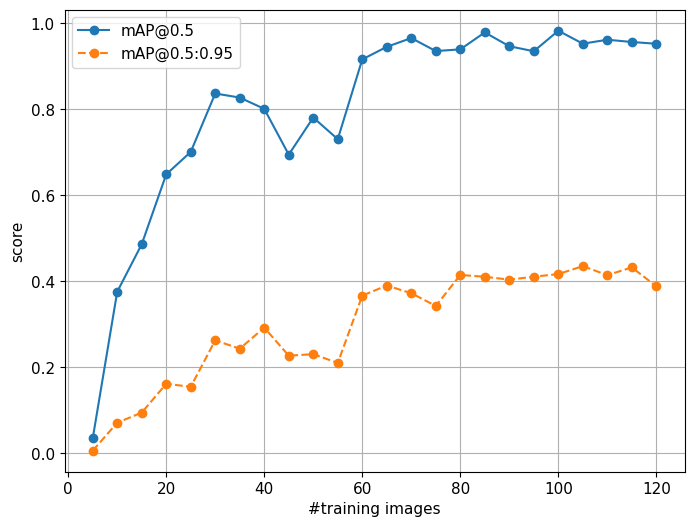

In [12]:
data_dir = data_dir
project_dir = project_dir
max_image_number = 120
start_image_num = 5
final_imag_num = max_image_number
num_interval = 5
epoch  = 50
save_name = "test_scores"
OptimumTrainImages(data_dir=data_dir,project_dir=project_dir,
                   max_image_number=max_image_number,start_image_num=start_image_num,
                   final_image_num=final_imag_num, 
                   num_interval=num_interval,epoch=epoch,save_name=save_name)


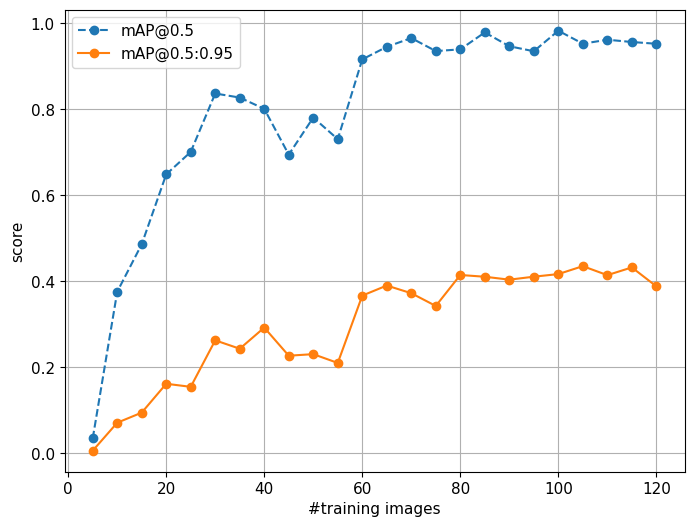

In [13]:
df = pd.read_csv(f"{project_dir}/{save_name}.csv")
num_train = df['num_train_image']
mAP_05 = df['mAP@0.5']
mAP_0595 = df['mAP@0.5..0.95']
fig,ax = plt.subplots(figsize=(8,6))
ax.plot(num_train, mAP_05, label='mAP@0.5', linestyle='--',marker='o')
ax.plot(num_train, mAP_0595, label='mAP@0.5:0.95',marker='o')
ax.set_xlabel('#training images')
ax.set_ylabel('score')
ax.grid(True)
ax.legend()
plt.show()

## Tracking with StrongSORT

- We also discussed tracking with StrongSORT in our paper. Once the YOLO model is ready, we can simply run the following cell with the usual arguments. Notice that StrongSORT suffers from multiple ID switches. 



- This notebook is just a demonstration, we highly recommend running the following command from terminal using as it will be way remarkably faster.

        python Yolov5_StrongSORT_OSNet/track_erdi.py --yolo-weights "best_droplet.pt" --source "datasets/videos/three_droplet.mp4" --conf-thres 0.45 --show-vid --config-strongsort "Yolov5_StrongSORT_OSNet/strong_sort/configs/strong_sort.yaml"


        
- Tracking video and tracks in MOT format will be saved to *project_dir/project_name* folder.

In [16]:
model_path = f"{project_dir}/{project_name}/weights/best.pt"
video_dir = video_path
conf_thresold = 0.45
project_dir = project_dir
sort_dir = "SORT_tracks"

os.system(f"python Yolov5_StrongSORT_OSNet/track.py --yolo-weights {model_path} \
      --source {video_dir} --conf-thres {conf_thresold} \
      --project {project_dir} --name {sort_dir} \
      --show-vid --save-txt --save-vid \
      --config-strongsort Yolov5_StrongSORT_OSNet/strong_sort/configs/strong_sort.yaml\
      ")

track: yolo_weights=['tutorial_data/three_droplet/weights/best.pt'], strong_sort_weights=/home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/Yolov5_StrongSORT_OSNet/weights/osnet_x0_25_msmt17.pt, config_strongsort=Yolov5_StrongSORT_OSNet/strong_sort/configs/strong_sort.yaml, source=datasets/videos/three_droplet.mp4, imgsz=[640, 640], conf_thres=0.45, iou_thres=0.5, max_det=1000, device=, show_vid=True, save_txt=True, save_conf=False, save_crop=False, save_vid=True, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=tutorial_data, name=SORT_tracks, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, hide_class=False, half=False, dnn=False
YOLOv5 🚀 2022-8-2 Python-3.10.8 torch-1.13.0+cu117 CUDA:0 (NVIDIA GeForce RTX 2070 Super, 7982MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
video 1/1 (1/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/v

video 1/1 (3/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.009s), StrongSORT:(0.020s)
video 1/1 (4/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.010s), StrongSORT:(0.018s)
video 1/1 (5/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.009s), StrongSORT:(0.018s)
video 1/1 (6/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.009s), StrongSORT:(0.018s)
video 1/1 (7/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.009s), StrongSORT:(0.018s)
video 1/1 (8/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplet

video 1/1 (50/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.017s)
video 1/1 (51/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (52/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.016s)
video 1/1 (53/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.016s)
video 1/1 (54/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (55/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 d

video 1/1 (99/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (100/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.017s)
video 1/1 (101/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.017s)
video 1/1 (102/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.017s)
video 1/1 (103/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.017s)
video 1/1 (104/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x64

video 1/1 (148/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.019s)
video 1/1 (149/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (150/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (151/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (152/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.017s)
video 1/1 (153/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x6

video 1/1 (197/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (198/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (199/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (200/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.017s)
video 1/1 (201/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (202/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x6

video 1/1 (246/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (247/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (248/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (249/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (250/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (251/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x6

video 1/1 (295/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (296/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.008s), StrongSORT:(0.017s)
video 1/1 (297/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.008s), StrongSORT:(0.017s)
video 1/1 (298/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.017s)
video 1/1 (299/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.017s)
video 1/1 (300/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x6

video 1/1 (344/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.019s)
video 1/1 (345/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (346/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (347/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.008s), StrongSORT:(0.017s)
video 1/1 (348/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.017s)
video 1/1 (349/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x6

video 1/1 (392/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (393/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (394/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (395/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.017s)
video 1/1 (396/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (397/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x6

video 1/1 (441/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (442/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (443/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (444/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (445/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (446/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x6

video 1/1 (490/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (491/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (492/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (493/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (494/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.019s)
video 1/1 (495/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x6

video 1/1 (539/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (540/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (541/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (542/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (543/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (544/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x6

video 1/1 (588/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.019s)
video 1/1 (589/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (590/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (591/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (592/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (593/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x6

video 1/1 (636/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (637/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (638/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 2 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (639/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.017s)
video 1/1 (640/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (641/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x6

video 1/1 (684/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (685/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.017s)
video 1/1 (686/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (687/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.017s)
video 1/1 (688/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.017s)
video 1/1 (689/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x6

video 1/1 (732/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.022s)
video 1/1 (733/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 2 droplets, Done. YOLO:(0.007s), StrongSORT:(0.017s)
video 1/1 (734/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (735/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (736/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (737/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x6

video 1/1 (780/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.019s)
video 1/1 (781/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.009s), StrongSORT:(0.018s)
video 1/1 (782/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (783/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.017s)
video 1/1 (784/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (785/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x6

video 1/1 (828/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.019s)
video 1/1 (829/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (830/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (831/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (832/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (833/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x6

video 1/1 (877/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (878/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (879/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.017s)
video 1/1 (880/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.019s)
video 1/1 (881/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (882/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x6

video 1/1 (926/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (927/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (928/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (929/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.016s)
video 1/1 (930/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.017s)
video 1/1 (931/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x6

video 1/1 (975/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.019s)
video 1/1 (976/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.019s)
video 1/1 (977/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (978/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (979/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (980/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x6

video 1/1 (1024/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (1025/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (1026/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (1027/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (1028/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.017s)
video 1/1 (1029/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (1073/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (1074/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.017s)
video 1/1 (1075/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (1076/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (1077/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (1078/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (1122/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (1123/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (1124/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (1125/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (1126/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (1127/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (1171/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.019s)
video 1/1 (1172/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.008s), StrongSORT:(0.017s)
video 1/1 (1173/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.017s)
video 1/1 (1174/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.017s)
video 1/1 (1175/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.017s)
video 1/1 (1176/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (1220/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.019s)
video 1/1 (1221/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (1222/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (1223/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (1224/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (1225/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (1269/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (1270/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (1271/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (1272/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (1273/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (1274/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (1318/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (1319/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (1320/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (1321/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (1322/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (1323/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (1367/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.019s)
video 1/1 (1368/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (1369/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.019s)
video 1/1 (1370/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (1371/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (1372/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (1416/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (1417/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (1418/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.017s)
video 1/1 (1419/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.017s)
video 1/1 (1420/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (1421/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (1465/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.009s), StrongSORT:(0.018s)
video 1/1 (1466/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.017s)
video 1/1 (1467/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (1468/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (1469/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (1470/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (1514/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (1515/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (1516/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.017s)
video 1/1 (1517/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.017s)
video 1/1 (1518/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (1519/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (1563/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.019s)
video 1/1 (1564/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (1565/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.017s)
video 1/1 (1566/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.017s)
video 1/1 (1567/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (1568/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (1612/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (1613/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (1614/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.021s)
video 1/1 (1615/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (1616/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (1617/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (1661/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (1662/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (1663/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (1664/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (1665/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (1666/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (1710/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.017s)
video 1/1 (1711/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (1712/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.017s)
video 1/1 (1713/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (1714/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (1715/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (1759/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.008s), StrongSORT:(0.018s)
video 1/1 (1760/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (1761/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (1762/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.017s)
video 1/1 (1763/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (1764/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (1808/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (1809/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (1810/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (1811/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (1812/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (1813/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (1857/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.019s)
video 1/1 (1858/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (1859/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (1860/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (1861/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (1862/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (1906/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.019s)
video 1/1 (1907/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.019s)
video 1/1 (1908/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.019s)
video 1/1 (1909/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.019s)
video 1/1 (1910/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.008s), StrongSORT:(0.018s)
video 1/1 (1911/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (1955/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.019s)
video 1/1 (1956/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (1957/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (1958/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (1959/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (1960/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (2004/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.020s)
video 1/1 (2005/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (2006/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.017s)
video 1/1 (2007/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (2008/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (2009/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (2053/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.019s)
video 1/1 (2054/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (2055/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (2056/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (2057/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (2058/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (2102/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.019s)
video 1/1 (2103/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (2104/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (2105/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (2106/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (2107/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (2151/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.020s)
video 1/1 (2152/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (2153/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (2154/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (2155/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.019s)
video 1/1 (2156/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (2200/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (2201/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (2202/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (2203/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (2204/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (2205/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (2249/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.019s)
video 1/1 (2250/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (2251/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (2252/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (2253/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (2254/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (2297/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.020s)
video 1/1 (2298/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (2299/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (2300/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (2301/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (2302/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (2346/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (2347/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (2348/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (2349/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.020s)
video 1/1 (2350/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (2351/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (2395/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.019s)
video 1/1 (2396/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (2397/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.017s)
video 1/1 (2398/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (2399/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (2400/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (2444/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (2445/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (2446/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (2447/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.008s), StrongSORT:(0.022s)
video 1/1 (2448/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (2449/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (2492/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.019s)
video 1/1 (2493/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (2494/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (2495/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (2496/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (2497/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (2541/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (2542/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (2543/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (2544/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (2545/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (2546/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (2590/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (2591/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (2592/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (2593/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (2594/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (2595/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (2639/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.019s)
video 1/1 (2640/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (2641/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (2642/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (2643/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (2644/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (2688/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (2689/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (2690/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (2691/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.017s)
video 1/1 (2692/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (2693/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (2737/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.019s)
video 1/1 (2738/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.017s)
video 1/1 (2739/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.017s)
video 1/1 (2740/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.017s)
video 1/1 (2741/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (2742/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (2786/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.020s)
video 1/1 (2787/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (2788/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (2789/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (2790/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (2791/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (2835/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (2836/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (2837/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.017s)
video 1/1 (2838/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (2839/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (2840/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (2884/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.019s)
video 1/1 (2885/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.008s), StrongSORT:(0.017s)
video 1/1 (2886/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.019s)
video 1/1 (2887/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (2888/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (2889/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (2933/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (2934/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (2935/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (2936/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (2937/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (2938/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (2982/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (2983/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (2984/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (2985/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (2986/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.019s)
video 1/1 (2987/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (3031/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (3032/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (3033/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 2 droplets, Done. YOLO:(0.007s), StrongSORT:(0.017s)
video 1/1 (3034/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (3035/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (3036/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (3080/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.019s)
video 1/1 (3081/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (3082/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (3083/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (3084/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (3085/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (3129/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.019s)
video 1/1 (3130/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.019s)
video 1/1 (3131/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.017s)
video 1/1 (3132/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.017s)
video 1/1 (3133/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (3134/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (3178/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (3179/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (3180/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (3181/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (3182/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (3183/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (3227/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 2 droplets, Done. YOLO:(0.006s), StrongSORT:(0.019s)
video 1/1 (3228/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (3229/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (3230/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (3231/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.019s)
video 1/1 (3232/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (3276/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.019s)
video 1/1 (3277/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (3278/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (3279/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.017s)
video 1/1 (3280/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.017s)
video 1/1 (3281/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (3325/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.019s)
video 1/1 (3326/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (3327/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (3328/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (3329/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (3330/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (3374/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (3375/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (3376/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (3377/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (3378/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (3379/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (3423/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (3424/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (3425/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.017s)
video 1/1 (3426/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.019s)
video 1/1 (3427/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (3428/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (3472/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.019s)
video 1/1 (3473/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (3474/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (3475/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (3476/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (3477/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (3521/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.019s)
video 1/1 (3522/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (3523/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (3524/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (3525/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (3526/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (3570/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.019s)
video 1/1 (3571/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (3572/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (3573/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (3574/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.017s)
video 1/1 (3575/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (3619/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.008s), StrongSORT:(0.019s)
video 1/1 (3620/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (3621/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (3622/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (3623/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (3624/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (3668/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.008s), StrongSORT:(0.018s)
video 1/1 (3669/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (3670/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (3671/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (3672/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (3673/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (3717/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.019s)
video 1/1 (3718/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.019s)
video 1/1 (3719/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (3720/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (3721/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.008s), StrongSORT:(0.018s)
video 1/1 (3722/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (3766/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.019s)
video 1/1 (3767/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.019s)
video 1/1 (3768/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (3769/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (3770/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.008s), StrongSORT:(0.018s)
video 1/1 (3771/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (3814/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.021s)
video 1/1 (3815/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (3816/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (3817/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (3818/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (3819/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (3863/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (3864/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (3865/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.019s)
video 1/1 (3866/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (3867/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (3868/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (3912/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.021s)
video 1/1 (3913/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (3914/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (3915/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (3916/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (3917/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (3961/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.022s)
video 1/1 (3962/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (3963/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (3964/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.009s), StrongSORT:(0.019s)
video 1/1 (3965/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (3966/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (4010/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (4011/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (4012/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (4013/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (4014/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (4015/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (4059/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.019s)
video 1/1 (4060/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (4061/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (4062/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (4063/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (4064/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (4107/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.019s)
video 1/1 (4108/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (4109/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (4110/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (4111/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (4112/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (4155/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.019s)
video 1/1 (4156/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (4157/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (4158/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.017s)
video 1/1 (4159/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (4160/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (4204/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (4205/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.017s)
video 1/1 (4206/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.017s)
video 1/1 (4207/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.017s)
video 1/1 (4208/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.017s)
video 1/1 (4209/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (4253/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (4254/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (4255/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (4256/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (4257/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (4258/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (4302/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (4303/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.019s)
video 1/1 (4304/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (4305/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (4306/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (4307/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (4351/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.019s)
video 1/1 (4352/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (4353/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (4354/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (4355/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (4356/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (4399/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.008s), StrongSORT:(0.018s)
video 1/1 (4400/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (4401/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (4402/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (4403/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (4404/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (4448/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.019s)
video 1/1 (4449/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.019s)
video 1/1 (4450/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.019s)
video 1/1 (4451/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.019s)
video 1/1 (4452/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.020s)
video 1/1 (4453/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (4496/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.009s), StrongSORT:(0.018s)
video 1/1 (4497/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.019s)
video 1/1 (4498/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (4499/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (4500/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.008s), StrongSORT:(0.018s)
video 1/1 (4501/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (4543/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.019s)
video 1/1 (4544/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (4545/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (4546/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (4547/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (4548/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (4592/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.019s)
video 1/1 (4593/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (4594/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (4595/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (4596/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (4597/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (4641/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (4642/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (4643/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (4644/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (4645/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (4646/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (4690/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (4691/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (4692/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (4693/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (4694/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (4695/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (4739/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.019s)
video 1/1 (4740/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (4741/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (4742/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.019s)
video 1/1 (4743/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.008s), StrongSORT:(0.018s)
video 1/1 (4744/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (4788/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.008s), StrongSORT:(0.019s)
video 1/1 (4789/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (4790/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (4791/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (4792/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.008s), StrongSORT:(0.018s)
video 1/1 (4793/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (4836/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.008s), StrongSORT:(0.018s)
video 1/1 (4837/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (4838/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (4839/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (4840/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (4841/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (4885/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.019s)
video 1/1 (4886/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (4887/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (4888/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.019s)
video 1/1 (4889/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (4890/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (4934/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (4935/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (4936/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (4937/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.019s)
video 1/1 (4938/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (4939/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (4982/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.021s)
video 1/1 (4983/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (4984/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (4985/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (4986/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (4987/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (5030/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (5031/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (5032/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (5033/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (5034/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (5035/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (5079/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.020s)
video 1/1 (5080/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (5081/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (5082/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.019s)
video 1/1 (5083/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (5084/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (5128/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (5129/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.008s), StrongSORT:(0.017s)
video 1/1 (5130/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (5131/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (5132/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (5133/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (5177/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.019s)
video 1/1 (5178/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (5179/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (5180/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (5181/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (5182/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (5226/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (5227/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (5228/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (5229/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (5230/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (5231/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (5275/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (5276/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (5277/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.017s)
video 1/1 (5278/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (5279/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (5280/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (5324/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.019s)
video 1/1 (5325/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (5326/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (5327/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (5328/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (5329/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (5373/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.022s)
video 1/1 (5374/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (5375/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (5376/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (5377/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (5378/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (5421/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.019s)
video 1/1 (5422/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (5423/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (5424/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (5425/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (5426/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (5470/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (5471/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (5472/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (5473/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (5474/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (5475/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (5519/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.019s)
video 1/1 (5520/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (5521/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (5522/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.019s)
video 1/1 (5523/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (5524/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (5568/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.021s)
video 1/1 (5569/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (5570/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (5571/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (5572/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (5573/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (5617/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.020s)
video 1/1 (5618/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (5619/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (5620/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (5621/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (5622/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (5666/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.019s)
video 1/1 (5667/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (5668/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (5669/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (5670/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (5671/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (5715/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.019s)
video 1/1 (5716/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (5717/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (5718/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (5719/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.008s), StrongSORT:(0.019s)
video 1/1 (5720/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (5764/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.019s)
video 1/1 (5765/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.019s)
video 1/1 (5766/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (5767/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (5768/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (5769/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (5813/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.019s)
video 1/1 (5814/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (5815/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (5816/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (5817/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (5818/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (5862/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (5863/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (5864/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (5865/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.019s)
video 1/1 (5866/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.008s), StrongSORT:(0.018s)
video 1/1 (5867/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (5911/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (5912/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (5913/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (5914/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (5915/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (5916/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (5960/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.020s)
video 1/1 (5961/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (5962/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (5963/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (5964/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (5965/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (6009/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.008s), StrongSORT:(0.018s)
video 1/1 (6010/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (6011/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (6012/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (6013/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (6014/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (6056/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.019s)
video 1/1 (6057/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (6058/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (6059/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (6060/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (6061/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (6105/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (6106/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (6107/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (6108/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.023s)
video 1/1 (6109/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.008s), StrongSORT:(0.018s)
video 1/1 (6110/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (6154/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.019s)
video 1/1 (6155/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (6156/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.019s)
video 1/1 (6157/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (6158/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (6159/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (6203/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.008s), StrongSORT:(0.018s)
video 1/1 (6204/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (6205/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.019s)
video 1/1 (6206/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (6207/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (6208/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (6252/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.008s), StrongSORT:(0.018s)
video 1/1 (6253/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.008s), StrongSORT:(0.017s)
video 1/1 (6254/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.008s), StrongSORT:(0.017s)
video 1/1 (6255/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.017s)
video 1/1 (6256/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.017s)
video 1/1 (6257/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (6301/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.019s)
video 1/1 (6302/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (6303/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (6304/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (6305/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (6306/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (6350/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.019s)
video 1/1 (6351/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (6352/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (6353/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (6354/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (6355/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (6399/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.019s)
video 1/1 (6400/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (6401/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (6402/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (6403/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (6404/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (6448/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (6449/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (6450/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (6451/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (6452/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (6453/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (6497/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (6498/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (6499/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (6500/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (6501/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (6502/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (6546/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (6547/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (6548/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (6549/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (6550/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.009s), StrongSORT:(0.018s)
video 1/1 (6551/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (6594/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 2 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (6595/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.019s)
video 1/1 (6596/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.019s)
video 1/1 (6597/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (6598/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.019s)
video 1/1 (6599/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (6643/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (6644/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (6645/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.008s), StrongSORT:(0.018s)
video 1/1 (6646/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (6647/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (6648/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (6692/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.019s)
video 1/1 (6693/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (6694/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (6695/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (6696/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.019s)
video 1/1 (6697/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (6741/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.019s)
video 1/1 (6742/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.020s)
video 1/1 (6743/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (6744/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (6745/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (6746/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (6790/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.008s), StrongSORT:(0.019s)
video 1/1 (6791/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (6792/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (6793/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (6794/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (6795/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (6838/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.019s)
video 1/1 (6839/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (6840/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (6841/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (6842/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (6843/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (6887/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.019s)
video 1/1 (6888/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (6889/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (6890/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (6891/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (6892/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (6936/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.008s), StrongSORT:(0.019s)
video 1/1 (6937/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.019s)
video 1/1 (6938/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (6939/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.019s)
video 1/1 (6940/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (6941/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (6985/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.019s)
video 1/1 (6986/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (6987/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (6988/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (6989/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (6990/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (7034/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.008s), StrongSORT:(0.021s)
video 1/1 (7035/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (7036/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (7037/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (7038/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (7039/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (7083/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.020s)
video 1/1 (7084/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (7085/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (7086/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (7087/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (7088/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (7132/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.019s)
video 1/1 (7133/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (7134/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (7135/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.008s), StrongSORT:(0.018s)
video 1/1 (7136/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.008s), StrongSORT:(0.018s)
video 1/1 (7137/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (7180/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.019s)
video 1/1 (7181/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (7182/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (7183/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.019s)
video 1/1 (7184/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.019s)
video 1/1 (7185/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (7229/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.019s)
video 1/1 (7230/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.019s)
video 1/1 (7231/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (7232/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (7233/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (7234/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (7278/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (7279/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.019s)
video 1/1 (7280/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.019s)
video 1/1 (7281/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (7282/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (7283/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (7327/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.019s)
video 1/1 (7328/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (7329/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (7330/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.008s), StrongSORT:(0.018s)
video 1/1 (7331/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (7332/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (7376/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.008s), StrongSORT:(0.018s)
video 1/1 (7377/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (7378/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (7379/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (7380/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (7381/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (7425/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (7426/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (7427/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (7428/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (7429/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (7430/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (7474/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (7475/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.008s), StrongSORT:(0.018s)
video 1/1 (7476/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (7477/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (7478/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (7479/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (7523/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (7524/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (7525/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (7526/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (7527/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.019s)
video 1/1 (7528/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (7572/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.009s), StrongSORT:(0.018s)
video 1/1 (7573/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.019s)
video 1/1 (7574/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (7575/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (7576/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (7577/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (7620/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.019s)
video 1/1 (7621/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (7622/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (7623/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (7624/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (7625/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (7669/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.019s)
video 1/1 (7670/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (7671/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (7672/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (7673/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (7674/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (7718/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (7719/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (7720/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (7721/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.019s)
video 1/1 (7722/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (7723/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (7767/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.019s)
video 1/1 (7768/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (7769/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.019s)
video 1/1 (7770/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (7771/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (7772/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (7816/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.019s)
video 1/1 (7817/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (7818/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (7819/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (7820/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (7821/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (7865/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.019s)
video 1/1 (7866/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (7867/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (7868/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (7869/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.019s)
video 1/1 (7870/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (7918/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.009s), StrongSORT:(0.018s)
video 1/1 (7919/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (7920/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.019s)
video 1/1 (7921/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (7922/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (7923/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (7967/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.019s)
video 1/1 (7968/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.019s)
video 1/1 (7969/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.019s)
video 1/1 (7970/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (7971/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (7972/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (8016/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.019s)
video 1/1 (8017/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (8018/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (8019/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (8020/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (8021/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (8065/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.020s)
video 1/1 (8066/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (8067/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (8068/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (8069/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.019s)
video 1/1 (8070/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (8113/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (8114/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.020s)
video 1/1 (8115/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.020s)
video 1/1 (8116/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.019s)
video 1/1 (8117/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (8118/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (8161/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.019s)
video 1/1 (8162/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (8163/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (8164/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (8165/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (8166/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (8208/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.019s)
video 1/1 (8209/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.019s)
video 1/1 (8210/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.019s)
video 1/1 (8211/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (8212/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (8213/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (8257/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (8258/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (8259/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (8260/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (8261/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (8262/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (8306/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.019s)
video 1/1 (8307/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (8308/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (8309/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (8310/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (8311/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (8355/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 4 droplets, Done. YOLO:(0.006s), StrongSORT:(0.021s)
video 1/1 (8356/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 2 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (8357/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 4 droplets, Done. YOLO:(0.007s), StrongSORT:(0.019s)
video 1/1 (8358/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.019s)
video 1/1 (8359/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (8360/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (8404/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (8405/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (8406/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.008s), StrongSORT:(0.017s)
video 1/1 (8407/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (8408/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (8409/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (8453/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.020s)
video 1/1 (8454/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (8455/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (8456/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (8457/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (8458/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (8502/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.019s)
video 1/1 (8503/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (8504/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (8505/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (8506/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (8507/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (8551/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.020s)
video 1/1 (8552/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (8553/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.020s)
video 1/1 (8554/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (8555/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.019s)
video 1/1 (8556/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (8600/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (8601/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (8602/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (8603/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (8604/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (8605/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (8649/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (8650/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (8651/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (8652/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (8653/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (8654/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (8698/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (8699/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (8700/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (8701/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (8702/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (8703/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (8747/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (8748/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (8749/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (8750/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (8751/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (8752/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (8796/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.019s)
video 1/1 (8797/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (8798/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (8799/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.019s)
video 1/1 (8800/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.019s)
video 1/1 (8801/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (8845/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.019s)
video 1/1 (8846/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (8847/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (8848/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (8849/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (8850/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (8894/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.019s)
video 1/1 (8895/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (8896/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (8897/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (8898/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (8899/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (8943/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.019s)
video 1/1 (8944/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (8945/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (8946/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (8947/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (8948/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

video 1/1 (8991/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.019s)
video 1/1 (8992/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.007s), StrongSORT:(0.018s)
video 1/1 (8993/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (8994/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.018s)
video 1/1 (8995/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4: 640x640 3 droplets, Done. YOLO:(0.006s), StrongSORT:(0.017s)
video 1/1 (8996/9034) /home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/datasets/videos/three_droplet.mp4:

Model: osnet_x0_25
- params: 203,568
- flops: 82,316,000
Successfully loaded pretrained weights from "/home/erkara/Dropbox/Follow/Misc/GitRepos/TrackingDroplets/Yolov5_StrongSORT_OSNet/weights/osnet_x0_25_msmt17.pt"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.weight', 'classifier.bias']


0

                                               THANK YOU FOR CHECKING OUT!